In [1]:
import numpy as np
import pandas as pd
import librosa
import scipy as sp
import matplotlib.pyplot as plt
import IPython.display as ipd
import torch
import noisereduce as nr
import seaborn as sns
import os
import cv2
import warnings
import pickle
warnings.filterwarnings("ignore")
from audiomentations import AdjustDuration
sns.set()

C:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Set Source
The <a href="https://www.kaggle.com/datasets/rtatman/british-birdsong-dataset">British Birdsong Dataset</a>  

## About Dataset
### Context:
Birds use songs and calls of varying length and complexity to attract mates, warn of nearby danger and mark their territory. This dataset contains a recordings of different birdsongs from bird species that can be found in Britain (although the recordings themselves are from many different locations).

### Content:
This is a dataset of bird sound recordings, a specific subset gathered from the Xeno Canto collection to form a balanced dataset across 88 species commonly heard in the United Kingdom. It was originally compiled by Dan Stowell and shared on Archive.org.

The copyright in each audio file is owned by the user who donated the file to Xeno Canto. Please see `"birdsong_metadata.tsv"` for the full listing, which gives the authors' names and the CC licences applicable for each file. The audio files are encoded as `.flac` files.

### Acknowledgements:
These recordings were collected by 68 separate birding enthusiasts and uploaded to and stored by xeno-canto: www.xeno-canto.org. If you make use of these recordings in your work, please cite the specific recording and include acknowledgement of and a link to the xeno-canto website.

**The following references are to help the group on the project, to clean up after we are done**

# References
- <a>https://github.com/IliaZenkov/sklearn-audio-classification/blob/master/sklearn_audio_classification.ipynb</a>
- <a>https://towardsdatascience.com/decoding-the-symphony-of-sound-audio-signal-processing-for-musical-engineering-c66f09a4d0f5</a>
- <a>https://www.freecodecamp.org/news/writing-good-commit-messages-a-practical-guide/</a>
- <a>http://librosa.org/doc/0.10.1/feature.html</a>
- <a>https://markdown.land</a>

# Problem Statement

In conservation efforts, it is often hard to estimate populations of a particular because of the timid nature of birds. Identifying the species by their bird songs would aid in such conservation efforts as it is non-intrusive.

# Motivation

We perceive bird songs to be distinctive and that different birds would likely produce different kind songs charactersitic of their species. Yet, it is often very diffiult to get a clear, full view of the particular bird as it may be well hidden within the depths of the forest, or it is simply too skittish and would fly away as we approach. By matching the audio features of bird songs to the species, we can help improve conservation efforts, allowing researchers to identify and estimate the population size of a particular species. Another benefit is to allow the general public, not just experienced bird watchers, to appreciate the diversity and beauty of nature in a different way. 

This project is by no means, anything close to new or groundbreaking. Yet, we find it interesting to process unstructured data and wish to explore beyond the curriculum of this module. Afterall, most of what we percieve in the real world are indeed unstructured data. This project serves as the invaluable learning experience for our team

# Metadata analysis

In [2]:
meta_data = pd.read_csv('./bird/birdsong_metadata.csv')
meta_data.head()

file_id         genus    species   english_cname who_provided_recording  \
0   132608      Acanthis    flammea  Common Redpoll         Jarek Matusiak   
1   132611      Acanthis    flammea  Common Redpoll         Jarek Matusiak   
2    35068      Acanthis    flammea  Common Redpoll             Sander Bot   
3    82715  Acrocephalus  palustris   Marsh Warbler         Dougie Preston   
4    64685  Acrocephalus  palustris   Marsh Warbler         Dougie Preston   

          country  latitude  longitute                     type  \
0          Poland   50.7932    15.4995       female, male, song   
1          Poland   50.7932    15.4995  flight call, male, song   
2     Netherlands   52.8176     6.4326               call, song   
3  United Kingdom   60.3539    -1.2689                     Song   
4  United Kingdom   60.3539    -1.2689                     Song   

                                             license  
0  http://creativecommons.org/licenses/by-nc-sa/3.0/  
1  http://creativecommons.org/licenses/by-nc-sa/3.0/  
2  http://creativecommons.org/licenses/by-nc-nd/2.5/  
3  http://creativecommons.org/licenses/by-nc-nd/2.5/  
4  http://creativecommons.org/licenses/by-nc-nd/2.5/

## Descriptions of Variables  
- `file_id`:
- `genus`:
- `species`:
- `english_cname`:
- `who_provided_recording`:
- `country`:
- `latitude`:
- `longitute`:
- `type`:
- `license`:

First and foremost, we need to understand the data that we are working on. One important thing is to know how many speicies of birds are there and the distributions of their number of recordings.

In [3]:
meta_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   file_id                 264 non-null    int64  
 1   genus                   264 non-null    object 
 2   species                 264 non-null    object 
 3   english_cname           264 non-null    object 
 4   who_provided_recording  264 non-null    object 
 5   country                 264 non-null    object 
 6   latitude                261 non-null    float64
 7   longitute               261 non-null    float64
 8   type                    264 non-null    object 
 9   license                 264 non-null    object 
dtypes: float64(2), int64(1), object(7)
memory usage: 20.8+ KB


<Axes: xlabel='english_cname'>

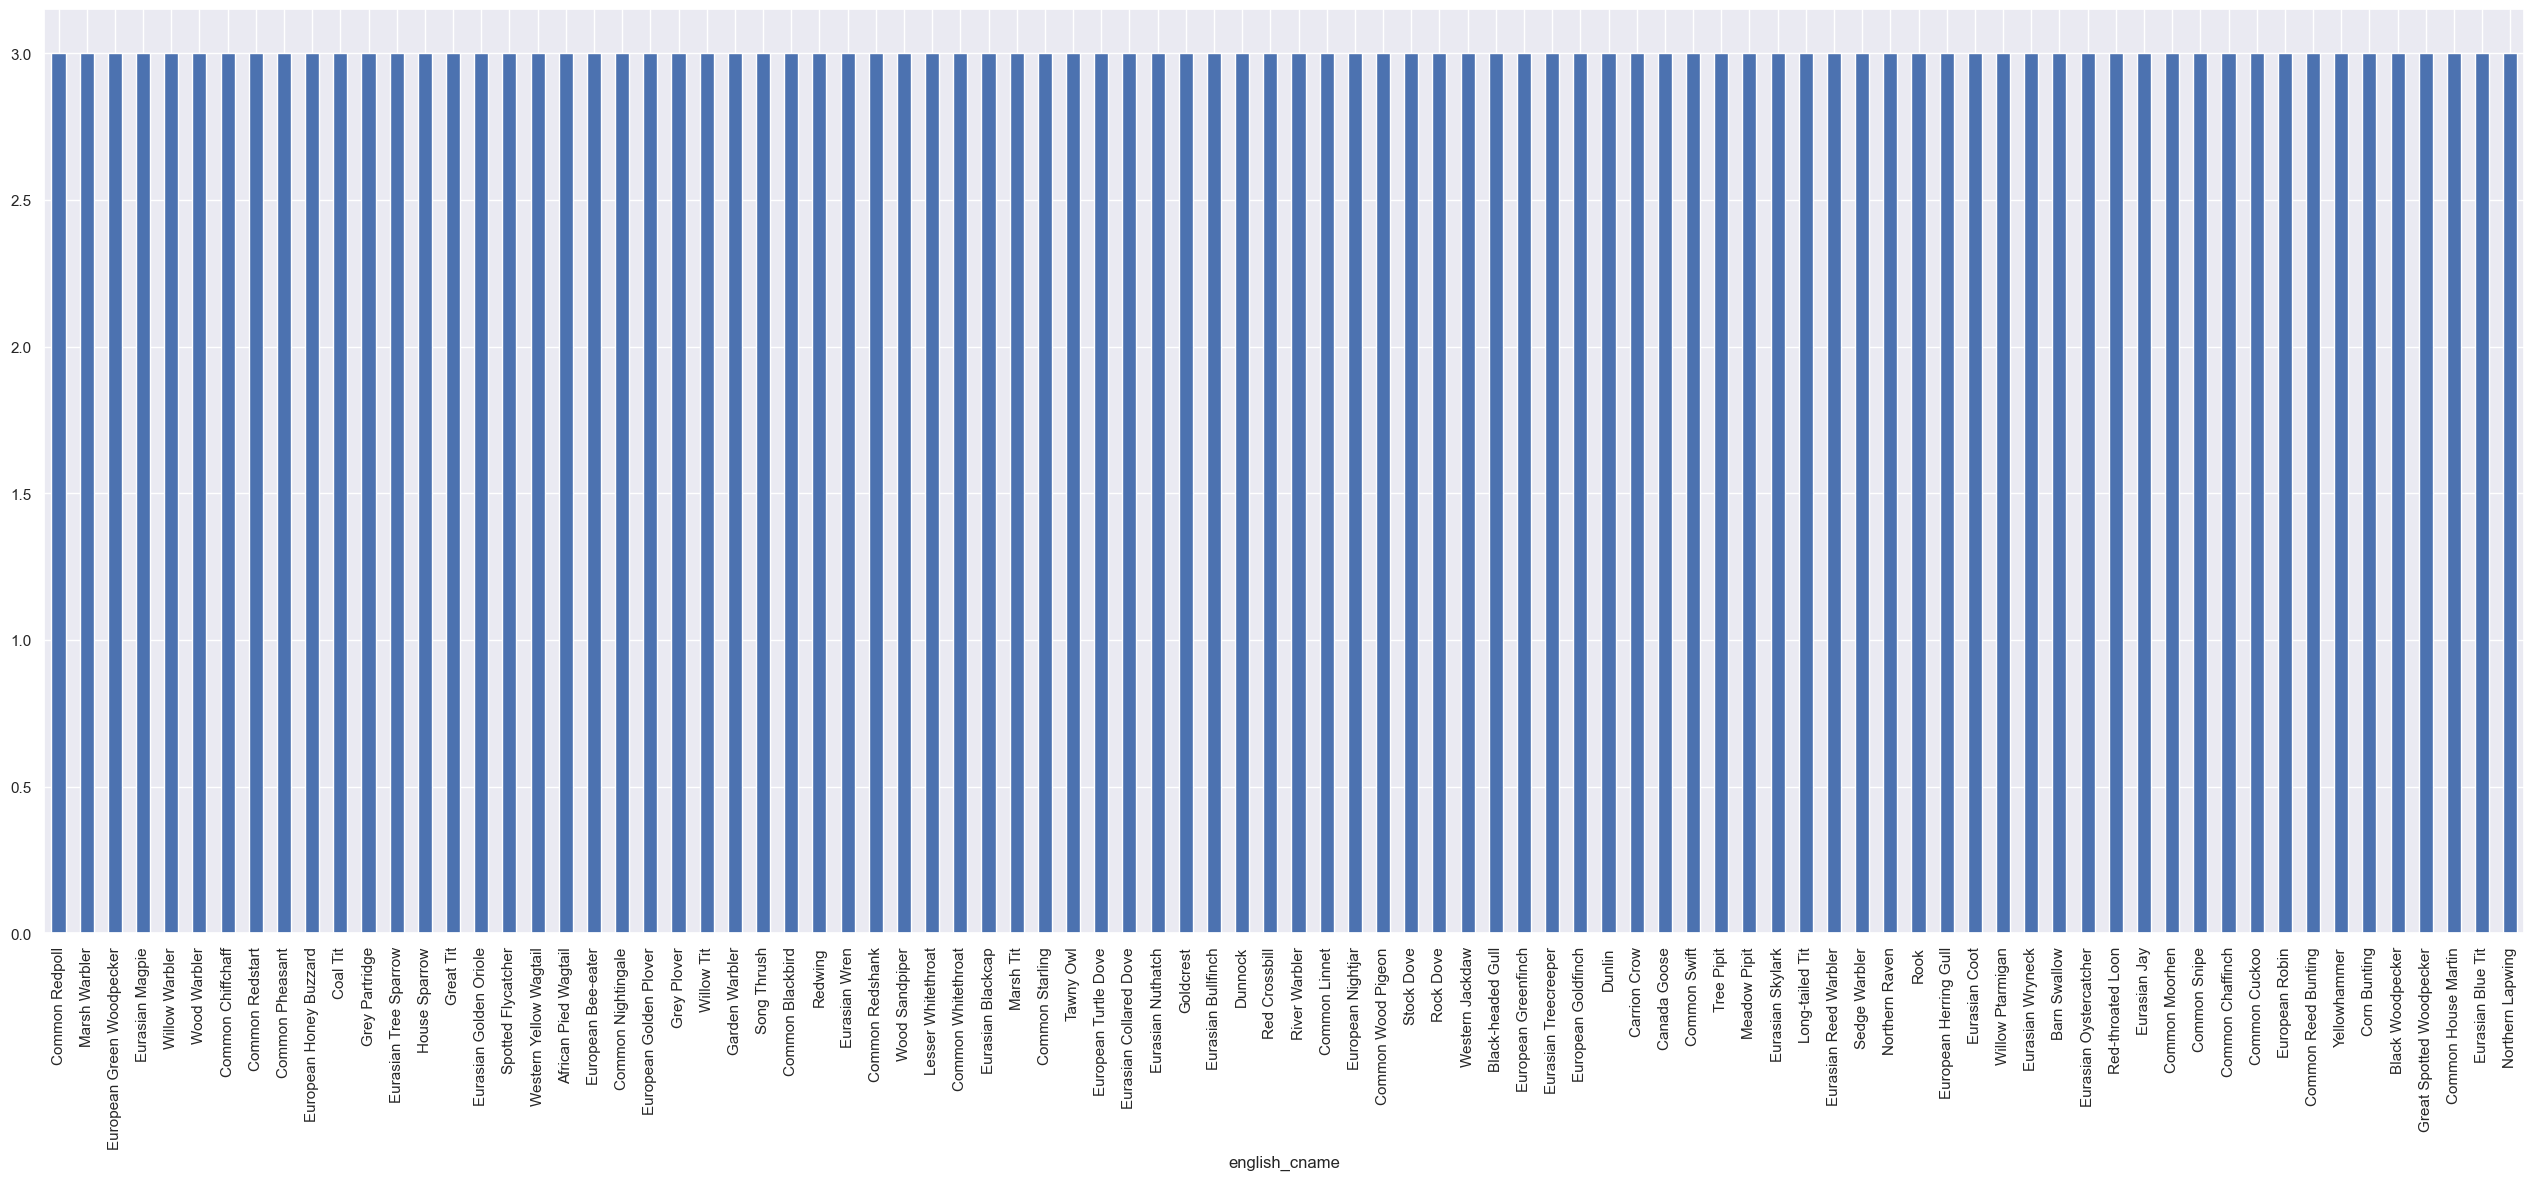

In [4]:
f = plt.figure(figsize=(32,12))
meta_data['english_cname'].value_counts().plot(kind='bar')

In [5]:
meta_data['english_cname'].describe()

count                264
unique                88
top       Common Redpoll
freq                   3
Name: english_cname, dtype: object

In [6]:
meta_data['english_cname'].value_counts()

english_cname
Common Redpoll               3
Marsh Warbler                3
European Green Woodpecker    3
Eurasian Magpie              3
Willow Warbler               3
                            ..
Black Woodpecker             3
Great Spotted Woodpecker     3
Common House Martin          3
Eurasian Blue Tit            3
Northern Lapwing             3
Name: count, Length: 88, dtype: int64

In [7]:
meta_data['english_cname'].value_counts().describe()

count    88.0
mean      3.0
std       0.0
min       3.0
25%       3.0
50%       3.0
75%       3.0
max       3.0
Name: count, dtype: float64

In [8]:
pd.unique(meta_data['english_cname'])

array(['Common Redpoll', 'Marsh Warbler', 'Sedge Warbler',
       'Eurasian Reed Warbler', 'Long-tailed Tit', 'Eurasian Skylark',
       'Meadow Pipit', 'Tree Pipit', 'Common Swift', 'Canada Goose',
       'Dunlin', 'European Nightjar', 'European Goldfinch',
       'Eurasian Treecreeper', 'European Greenfinch', 'Black-headed Gull',
       'Western Jackdaw', 'Rock Dove', 'Stock Dove', 'Common Wood Pigeon',
       'Northern Raven', 'Carrion Crow', 'Rook', 'Common Cuckoo',
       'Eurasian Blue Tit', 'Common House Martin',
       'Great Spotted Woodpecker', 'Black Woodpecker', 'Corn Bunting',
       'Yellowhammer', 'Common Reed Bunting', 'European Robin',
       'Common Chaffinch', 'Eurasian Coot', 'Common Snipe',
       'Common Moorhen', 'Eurasian Jay', 'Red-throated Loon',
       'Eurasian Oystercatcher', 'Barn Swallow', 'Eurasian Wryneck',
       'Willow Ptarmigan', 'European Herring Gull', 'Common Linnet',
       'River Warbler', 'Red Crossbill', 'Common Nightingale',
       'European

It looks like we have **88** unique bird species (based on their English common names), and every species have exactly **3** recordings. This is because the **standard deviation** of the `value_counts()` data is **0** and the **mean** is **0**. This tells us that we have a balanced number of classes.

Next, we will also be looking at the distribution of the locations that these recordings were made. We see that most of the recordings were taken in the United Kingdom. 

<Axes: xlabel='country'>

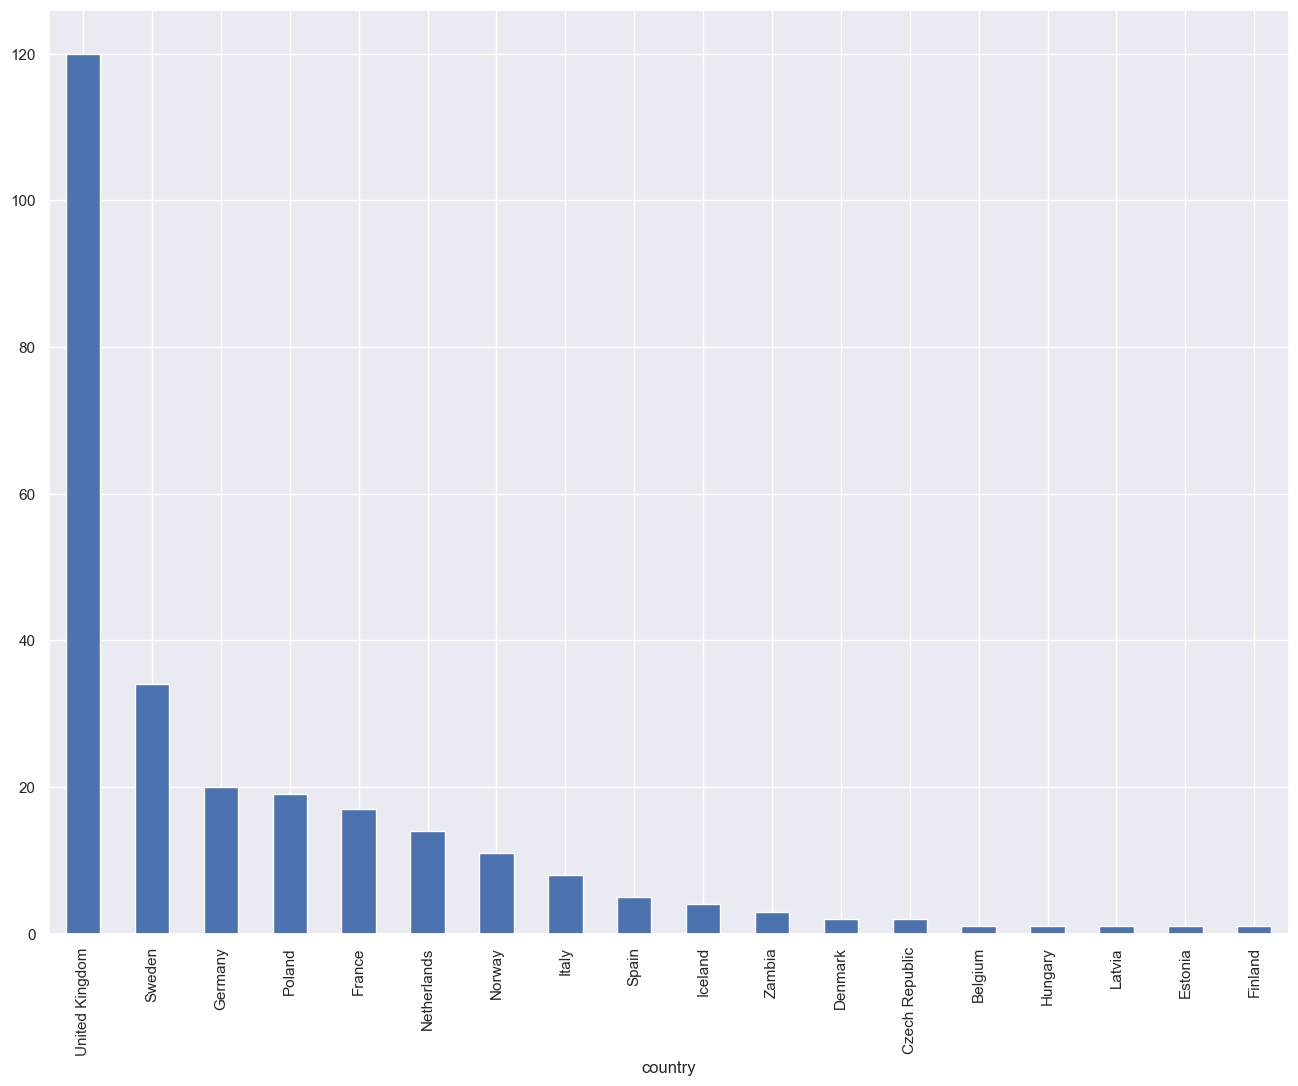

In [9]:
f = plt.figure(figsize=(16, 12))
meta_data['country'].value_counts().plot(kind='bar')

# **Audio Exploratory Data Analysis**  

Next, we will explore the audio data. Just as we need a decent foundational understanding of statistics for general numeric analysis, we also need to understand how sound works.

## **Understanding Sound and Wave**

Sound is a mechanical disturbance from a state of equilibrium that propagates through an elastic material medium <a href="https://www.britannica.com/science/sound-physics">[1]</a>

(to include brief explanation)  

A wave form contains **measurable** information such as the `amplitude` and `period`.   

Amplitude is the the maximum displacement or distance moved by a point on a vibrating body or wave measured from its equilibrium position <a href="https://www.britannica.com/science/amplitude-physics">[2]</a>. Amplitude is what we percieve *"loudness"* to be, a positive relationship. 

Period is the interval of time it takes for a motion to repeat <a href="https://www.britannica.com/science/period-physics">[3]</a>. Particularly, we are interested in the *frequency*. Frequency is such that  

<p style="text-align: center">$frequency = \frac{1}{period}$</p>

it is how we perceive *"pitch"* to be, a positive relationship.  

Another important concept is the *intensity* of sound. It is the ratio between the energy of the wave propagation and the area it is directed to.  **Decibel** measures  the ratio between two intensities, such as the relative loudness of sounds <a href="https://www.britannica.com/science/decibel">[4]</a>. Sometimes, we would use the reference intensity of the **threshold of hearing**, which is the lowest intensity of sound that is audible.

## **Digital representation of Sound**

Sound in real world is an analog data, which is **continuous** and can take **infinite** range. We try to replicate and represent this analog data in a digital data, which is **discrete**, and takes **limited** range. The resultant ADC(analog-to-digital conversion) of sound, is **digital audio signal**, also known as **pulse-code modulation**.

### The ADC Process

There are broadly, two steps in the ADC process.
- Sampling
- Qunatisation

(to include brief explanation)

**Sampling** refers to taking the *array* of amplitudes occuring at each constant interval, $T$. The **sampling rate**, $S_r$ is given by $S_r = \frac{1}{T}$. The sampling rate represents the number of samples that we have in each second of the digital signal.  

In quantisation, we group amplitude values closest to the assigned discrete **quantisation values**, which introduces **quanitsation error**. The higher the **quantisation resolution** (more discrete quantisation values), the lower the **quantisation error**. 


## **Framing**

We are not only interested in amplitude at each discrete time interval, we are also interested in the *variation* of amplitude across time. 

As such, we want to group these time intervals in a **frame**. (also to introduce to the concept of Nyquist Frequency). 

(Introduce the concept of the hop length)

(Introduce why frames are in a particular way)

Note that our frame size is usually in powers of 2 so it allows us to take advantage of **Fast Fourier Transform**

# **Time Domain Exploration**

## **Amplitude Envelope**

Amplitude envelope shows the **maximum amplitude** given in **each frame**. `librosa` does not provide a direct way in finding the amplitude envelope, and hence we defined our own function.

## **Root-Mean-Squared (RMS) Energy**
RMS energy represents the **overall intensity** of the signal by taking into account of all of the frames. This is abstracted by the feature methods in `librosa`. RMS energy is another indicator of loudness, and is less sensitive to outliers than Amplitude Envelope

<p style="text-align: center"><code>librosa.feature.rms(*, y=None, S=None, frame_length=2048, hop_length=512, center=True, pad_mode='constant', dtype=<class 'numpy.float32'>)</code></p>

## **Zero Crossing Rate**
It is the number of times a signal crosses the horizontal axis (0). Generally, the higher the number of zero corssing rate, the higher the "pitch" is. This is also abstracted by the feature methods in `librosa`.

<p style="text-align: center"><code>librosa.feature.zero_crossing_rate(y, *, frame_length=2048, hop_length=512, center=True, **kwargs)</code></p>

We will be looking at two samples of the same species, the **Common Redpoll**, as well as samples from **Marsh Warbler**. Play the audio clip to have a sense of how the bird song sounds like.

In [10]:
# Constant declaration

FRAME_SIZE = 1024
HOP_LEN = 512
SAMPLE_RATE = 22050

# these are common parameters

# Function Definitions

# Librosa does not have a built-in Amplitude Envelope extractor, so we need to create our own
# amplitude envelope (overlapping frames to account for losses at the edges)
# returns an array, used list comprehension. For each of the frame interval get the max (amplitude), and append to the array, interating by the hop lengths
def amplitude_envelope(signal, frame_size, hop_length):
    return np.array([max(signal[i:i+frame_size]) for i in range(0, len(signal), hop_length)])


# plots a waveform graph for ONE sample
def plot_waveform(address, title):
    waveform, sample_rate = librosa.load(address)
    # important to specify color in .waveshow() otherwise it may not work as per documentation
    ae = amplitude_envelope(waveform, FRAME_SIZE, HOP_LEN)
    # take every index of the time interval, multiply by the hop length we defined, then divide by the rate to get actual time transpired
    t = np.arange(len(ae)) * HOP_LEN / sample_rate

    zrc = librosa.feature.zero_crossing_rate(y=waveform, frame_length=FRAME_SIZE, hop_length=HOP_LEN)[0]
    rms = librosa.feature.rms(y=waveform, frame_length=FRAME_SIZE, hop_length=HOP_LEN)[0]
    t_rms = np.arange(len(rms)) * HOP_LEN / sample_rate
    t_zrc = np.arange(len(zrc)) * HOP_LEN / sample_rate
    
    plt.figure(figsize=(16,12))

    librosa.display.waveshow(waveform, sr=sample_rate, color="b", alpha=0.5) # alpha corresponds to transparency (visualising density)
    plt.plot(t, ae, color="r", label="Amplitude Envelope")
    plt.plot(t_rms, rms, color="g", label="RMS Energy")
    plt.plot(t_zrc, zrc, color="y", label="Zero Crossing Rate")
    plt.xlabel('Time / s')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.legend()
    plt.show()


# get basic information of the audio clip
def get_basic_info(path):
    audioData, sampleRate = librosa.load(path)
    print("Duration of audio clip: {:.2f}s".format(librosa.get_duration(path=path)))
    # adjusted to 2 decimal places to keep the values neater, as we do not need to show so many precision
    print("Sample size of audio clip (one parameter for mono, two for stereo):", audioData.shape)
    print("Sample Rate of aduio clip:", sampleRate)


#################################################################
#           Functions for Comparing The different Features     #
################################################################

# The function will compare which is of the shorter duration, and load them to be the same duration for better visualisation

def find_shorter_duration(path1, path2):
    duration1 = librosa.get_duration(path=path1)
    duration2 = librosa.get_duration(path=path2)
    return min(duration1, duration2)

def compare_ampltidue_envelope(path1, path2, title1, title2):
    duration = find_shorter_duration(path1, path2)
    signal1, sr1 = librosa.load(path1, duration=duration)
    signal2, sr2 = librosa.load(path2, duration=duration)
    ae1 = amplitude_envelope(signal1, FRAME_SIZE, HOP_LEN)
    ae2 = amplitude_envelope(signal2, FRAME_SIZE, HOP_LEN)
    t1 = np.arange(len(ae1)) * HOP_LEN / sr1
    t2 = np.arange(len(ae2)) * HOP_LEN / sr2
    plt.figure(figsize=(16,12))
    plt.ylim(0, 0.3)
    plt.plot(t1, ae1, color='r', label=title1)
    plt.plot(t2, ae2, color='b', label=title2)
    plt.title("Amplitude Envelope")
    plt.xlabel('Time / s')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

def compare_rms_energy(path1, path2, title1, title2):
    duration = find_shorter_duration(path1, path2)
    signal1, sr1 = librosa.load(path1, duration=duration)
    signal2, sr2 = librosa.load(path2, duration=duration)
    rms1 = librosa.feature.rms(y=signal1, frame_length=FRAME_SIZE, hop_length=HOP_LEN)[0]
    rms2 = librosa.feature.rms(y=signal2, frame_length=FRAME_SIZE, hop_length=HOP_LEN)[0]
    t1 = np.arange(len(rms1)) * HOP_LEN / sr1
    t2 = np.arange(len(rms2)) * HOP_LEN / sr2
    plt.figure(figsize=(16,12))
    plt.ylim(0, 0.1)
    plt.plot(t1, rms1, color='r', label=title1)
    plt.plot(t2, rms2, color='b', label=title2)
    plt.title("RMS Energy")
    plt.xlabel('Time / s')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

def compare_zrc(path1, path2, title1, title2):
    duration = find_shorter_duration(path1, path2)
    signal1, sr1 = librosa.load(path1, duration=duration)
    signal2, sr2 = librosa.load(path2, duration=duration)
    zrc1 = librosa.feature.zero_crossing_rate(y=signal1, frame_length=FRAME_SIZE, hop_length=HOP_LEN)[0]
    zrc2 = librosa.feature.zero_crossing_rate(y=signal2, frame_length=FRAME_SIZE, hop_length=HOP_LEN)[0]
    t1 = np.arange(len(zrc1)) * HOP_LEN / sr1
    t2 = np.arange(len(zrc2)) * HOP_LEN / sr2
    plt.figure(figsize=(16,12))
    plt.ylim(0, 700)
    # We want to find the ACTUAL ZRC, not the normalised one
    plt.plot(t1, zrc1*FRAME_SIZE, color='r', label=title1)
    plt.plot(t2, zrc2*FRAME_SIZE, color='b', label=title2)
    plt.title("Zero Crossing Rate")
    plt.xlabel('Time / s')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

    
######################################################################

## Getting Started

Let's first *listen* to the data that we will be working on. We will explore just two birds first, namely **Common Redpoll** and **Marsh Warbler**. 

**Note:** If you are viewing this document on GitHub, you would not be able to play and listen to the audio. To listen to the audio, please download the `.ipynb` notebook.

## **Common Redpoll**

Bird song sample `xc132608` of the **Common Redpoll**

In [11]:
ipd.Audio("./bird/songs/songs/xc132608.flac")

We check the basic information of the audio clip

In [12]:
get_basic_info("./bird/songs/songs/xc132608.flac")

Duration of audio clip: 38.56s
Sample size of audio clip (one parameter for mono, two for stereo): (850176,)
Sample Rate of aduio clip: 22050


In [13]:
print(librosa.load("./bird/songs/songs/xc132608.flac"))

(array([-1.34459697e-07,  1.11351255e-07, -8.19854904e-08, ...,
        1.25055521e-12,  4.54747351e-13, -1.36424205e-12], dtype=float32), 22050)


**Information** 

We see that what `librosa` is doing when we call the `.load()` method is to return an **array of float (specified to 32bits)**, as well as the **sampling rate**. This array of float datatypes correspond to the **amplitude** taken at discrete time interval, specified by the **sampling rate (default to 22050)**. Note that by default, `librosa` will read the audio in **mono channel** and we work with mono as well due to its simplicity. In the case of birdsongs, mono would work fine as we would not lose crucial information.

## Visualising Time-domain Features

Next, we proceed to explore the time-domain features. Refer to the function definition on how the features were extracted.

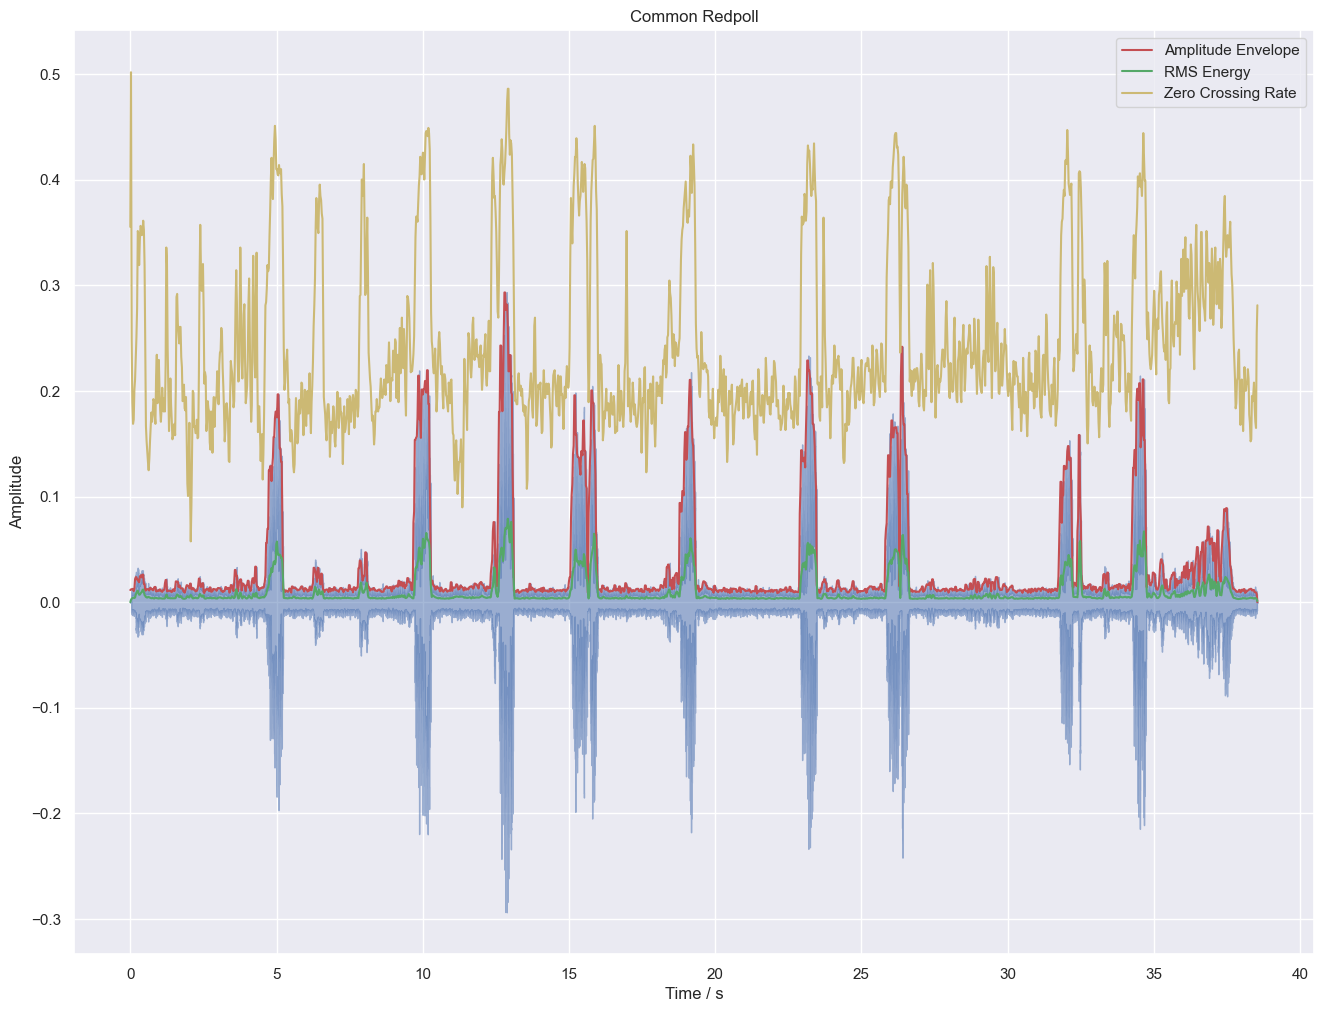

In [14]:
plot_waveform("./bird/songs/songs/xc132608.flac", "Common Redpoll")

## **Marsh Warbler**

Next, we will do the same thing for the bird species **Marsh Warbler**

Audio sample `xc82715` of **Marsh Warbler**

In [15]:
ipd.Audio("./bird/songs/songs/xc82715.flac")

In [16]:
get_basic_info("./bird/songs/songs/xc82715.flac")

Duration of audio clip: 16.22s
Sample size of audio clip (one parameter for mono, two for stereo): (357696,)
Sample Rate of aduio clip: 22050


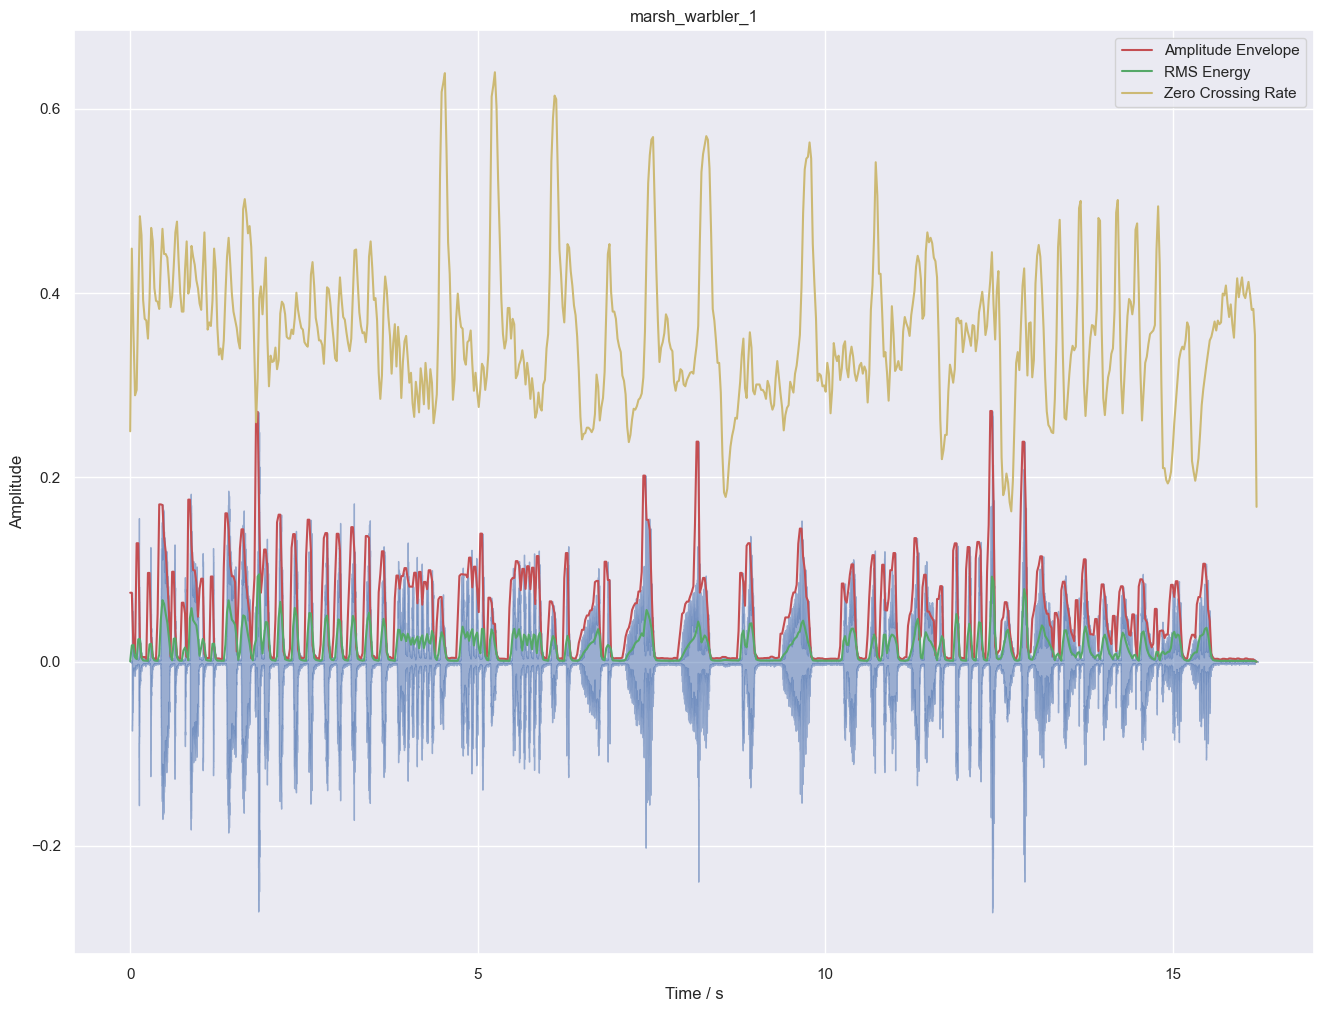

In [17]:
plot_waveform("./bird/songs/songs/xc82715.flac", "marsh_warbler_1")

# Initial Analysis

At first glance, it is quite easy to see that the time features of the different birds are quite different. To better visualise this, let's compare the individual features.

## Comparison between Amplitude Envelope

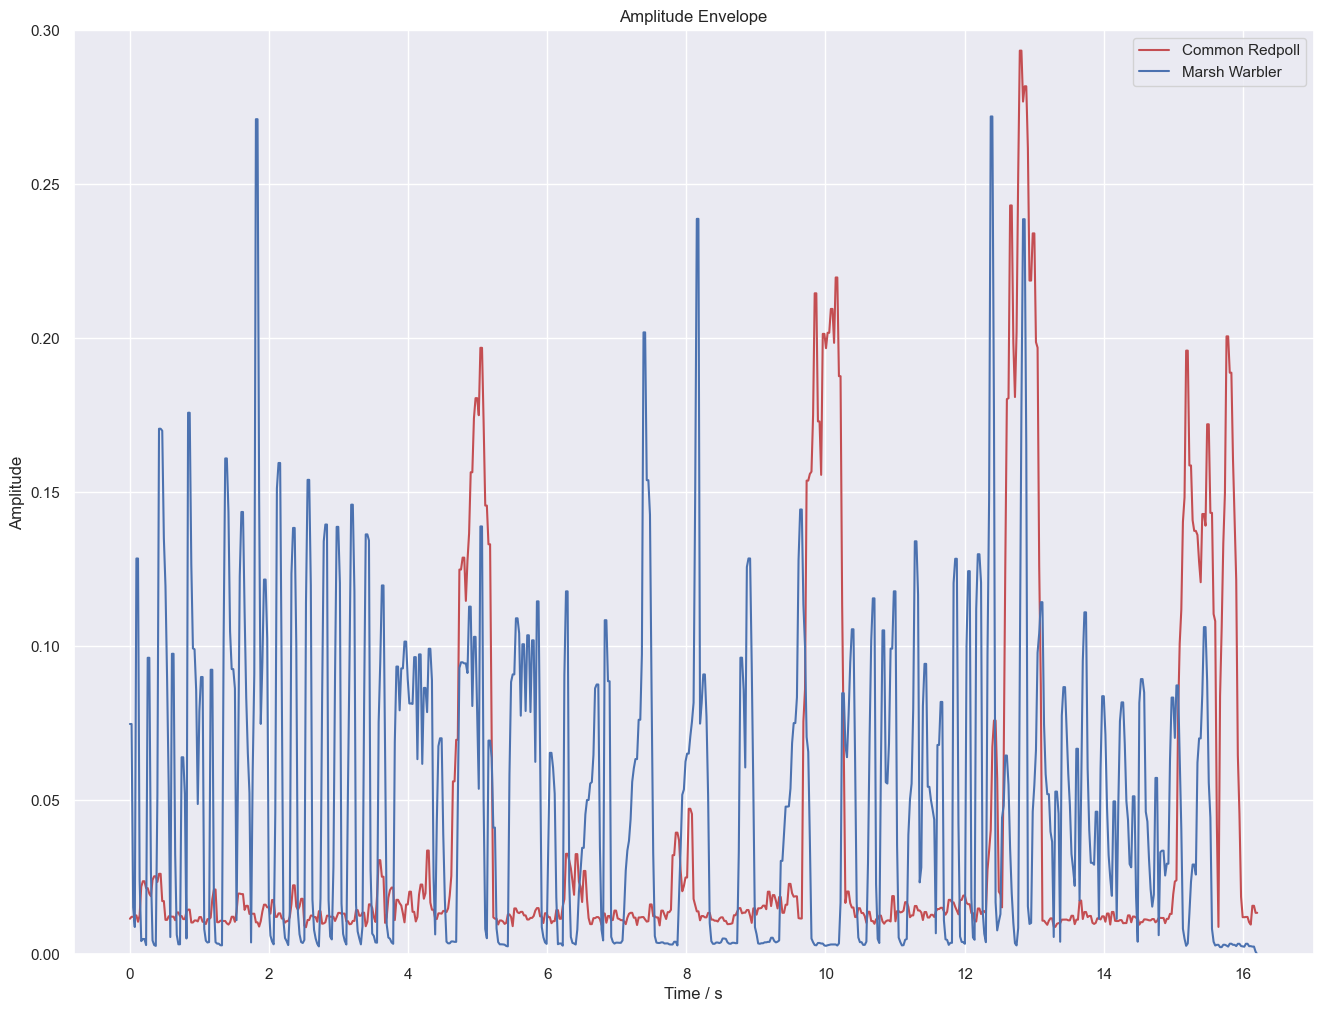

In [18]:
compare_ampltidue_envelope("./bird/songs/songs/xc132608.flac", "./bird/songs/songs/xc82715.flac", "Common Redpoll", "Marsh Warbler")

The amplitude envelope in this case seemed to not be a very clear feature for the case of Common Redpoll and Marsh Warbler as their peaks are rather similar. Aother distinct feature is that the *period* of the bird song for Marsh Warbler is much shorter, hinting a signficant difference between their frequency.  

**Note:** Our function truncates the audio to fit whichever is shorter. See function definitions for more details.

## Comparison between RMS Energy

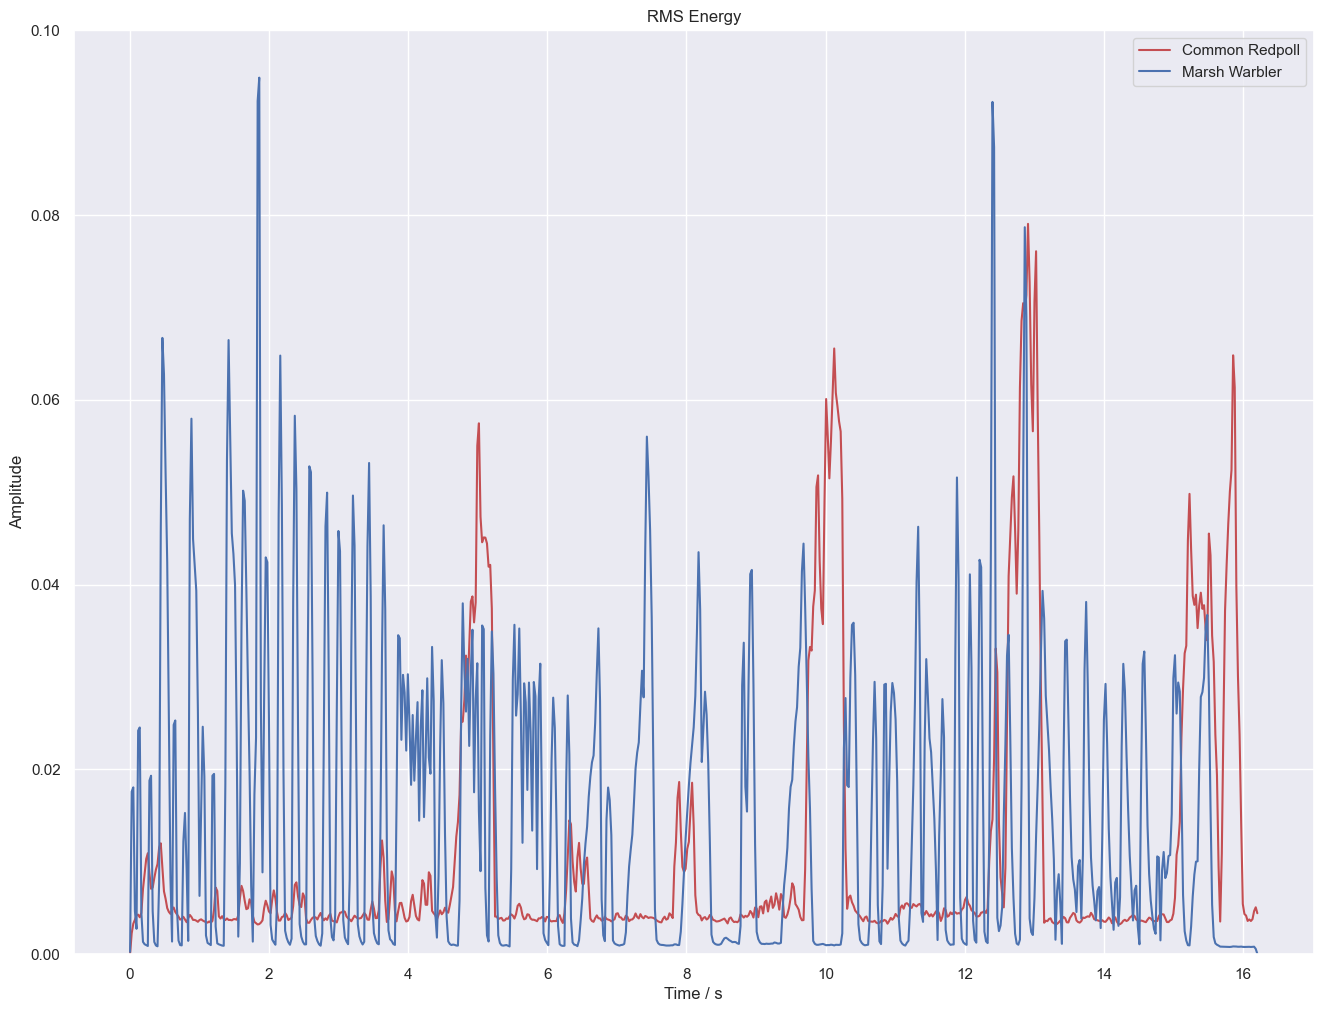

In [19]:
compare_rms_energy("./bird/songs/songs/xc132608.flac", "./bird/songs/songs/xc82715.flac", "Common Redpoll", "Marsh Warbler")

We see that in this case, Marsh Warbler has a higher peak than that Common Redpoll, which signified higher intensity of its birdsong. However, it remains clear that the most distinctive part about them is the frequency.

## Comparison between Zero Crossing Rate

Note that Zero Crossing Rates on the previous graphs are the **normalised** ones. In this comparison, we converted them into the **actual** crossing rates. This is done by by mulitplying the ZCR by its frame length.

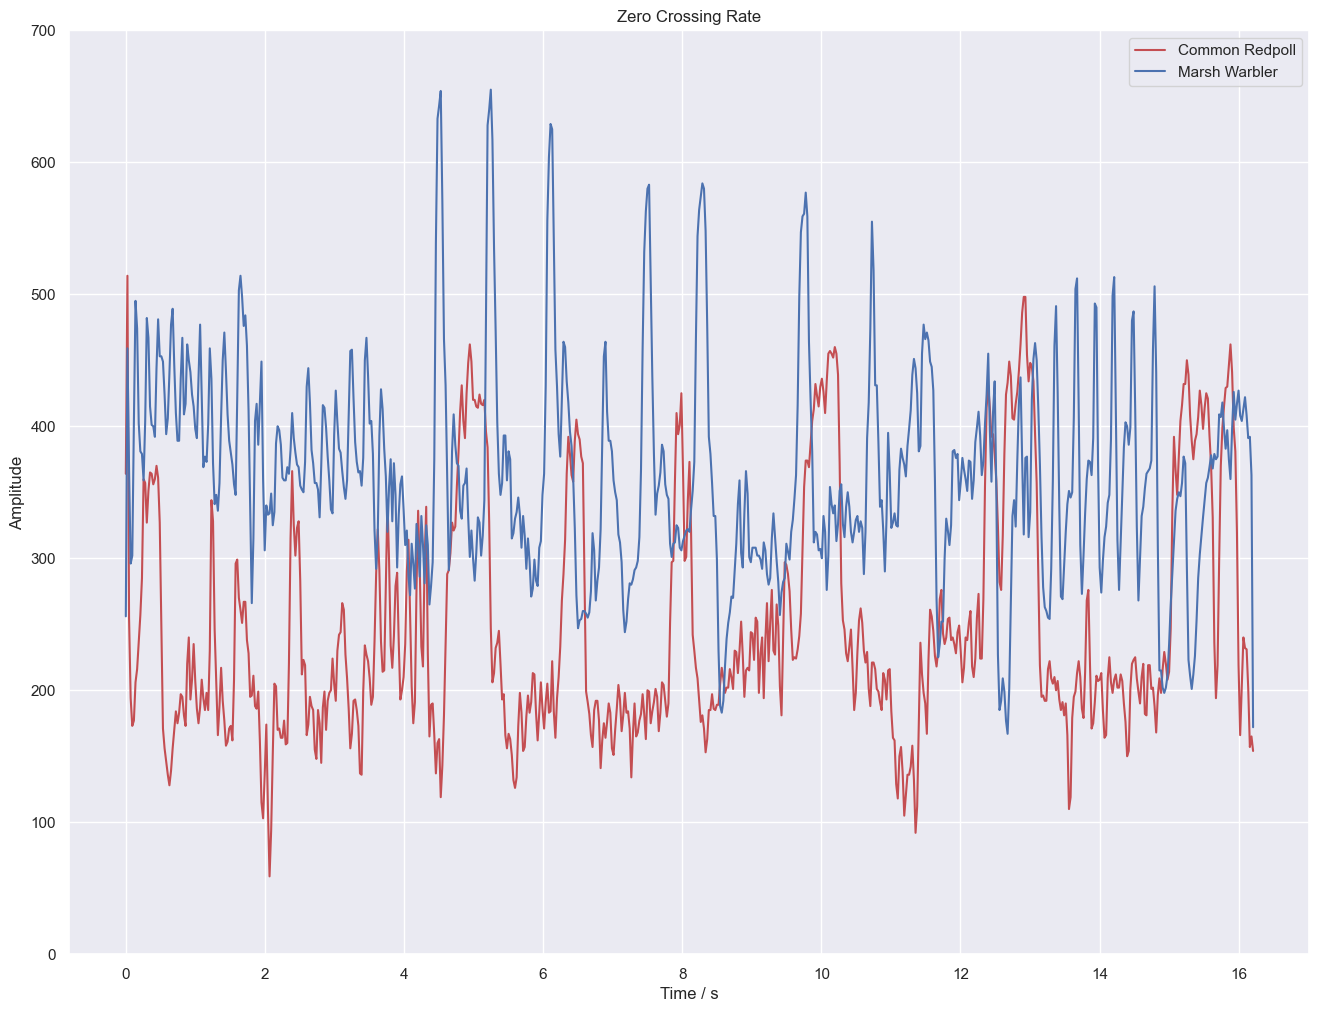

In [20]:
compare_zrc("./bird/songs/songs/xc132608.flac", "./bird/songs/songs/xc82715.flac", "Common Redpoll", "Marsh Warbler")

We see that the Marsh Warbler has a higher Zero Crossing Rate than Common Redpoll, which signified a higher "pitch" (*note: there are different mathematical models representing perceived pitch and actual pitch, which is beyond the scope of this project and we will just continue to use pitch to describe pitch as we know it*). This also signified that **frequency** has an important role in differentiating which birds are they.

# **Frequency Domain**

## **Fourier Transformation**
The general (and very superficial) concept is that for each frequency, we want to find a sinusoid counterpart, optimise their phase difference, such that we can find their similarity in terms of the magnitude. Freuqency with higher magnitude would suggest that it is more important for that signal. The actual mathematics has been abstracted by the different libraries.

## **Frequency Spectrum**
Frequency spectrum make use of variations of Fourier Transformation. The resultant graph is a an amplitude against frequency. It allows to see the distribution of the frequency bands for the different audio signals.

## **Spectral Centroid**
Spectral centroid shows where the frequency bands are **concentrated** at. It help us to measure the "brightness" or "dullness" of the audio. The general concept is that it is a weighted mean of frequencies. The computations has been abstracted by `librosa`.

<p style="text-align: center"><code>librosa.feature.spectral_centroid(*, y=None, sr=22050, S=None, n_fft=2048, hop_length=512, freq=None, win_length=None, window='hann', center=True, pad_mode='constant')</code></p>

In [21]:
# Function Definitions

def plot_frequency_spectrum(path, title):
    y, sr = librosa.load(path)
    ft = np.fft.fft(y)
    magnitude = np.absolute(ft)
    frequency = np.linspace(0, sr, len(ft))
    frequency_bins = int(len(frequency) * 0.5)  # Nyquist Frequency, and so we don't create a mirror
    plt.figure(figsize=(16, 8))
    plt.plot(frequency[:frequency_bins], magnitude[:frequency_bins])
    plt.xlabel("Freuqency / Hz")
    plt.ylabel("Magnitude")
    plt.title("Frequency Spectrum of " + title)
    plt.xlabel('Frequency / Hz')
    plt.ylabel('Amplitude')
    plt.show()    


def compare_frequency_spectrum(path1, path2, title1, title2):
    duration = find_shorter_duration(path1, path2)
    y1, sr1 = librosa.load(path1, duration=duration)
    y2, sr2 = librosa.load(path2, duration=duration)
    ft1 = np.fft.fft(y1)
    ft2 = np.fft.fft(y2)
    magnitude1 = np.absolute(ft1)
    magnitude2 = np.absolute(ft2)
    frequency1 = np.linspace(0, sr1, len(ft1))
    frequency2 = np.linspace(0, sr2, len(ft2))
    frequency_bins1 = int(len(frequency1) * 0.5)
    frequency_bins2 = int(len(frequency2) * 0.5)
    plt.figure(figsize=(16, 8))
    plt.plot(frequency1[:frequency_bins1], magnitude1[:frequency_bins1], alpha=0.5, color="r", label=title1)
    plt.plot(frequency2[:frequency_bins2], magnitude2[:frequency_bins2], alpha=0.5, color="b", label=title2)
    plt.xlabel("Freuqency / Hz")
    plt.ylabel("Magnitude")
    plt.title("Frequency Spectrum Comparison")
    plt.xlabel('Frequency / Hz')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()    


def plot_spectral_centroid(path, title):
    y, sr = librosa.load(path)
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=HOP_LEN, n_fft=FRAME_SIZE)[0]
    frames = range(len(centroid))
    t = librosa.frames_to_time(frames)
    plt.figure(figsize=(16,8))
    plt.plot(t, centroid, color="b")
    plt.xlabel("Time / s")
    plt.ylabel("Spectral Centroid / Hz")
    plt.title("Spectral Centroid of " + title)
    plt.show()


def compare_spectral_centroid(path1, path2, title1, title2):
    duration = find_shorter_duration(path1, path2)
    y1, sr1 = librosa.load(path1, duration=duration)
    centroid1 = librosa.feature.spectral_centroid(y=y1, sr=sr1, hop_length=HOP_LEN, n_fft=FRAME_SIZE)[0]
    frames1 = range(len(centroid1))
    t1 = librosa.frames_to_time(frames1)

    y2, sr2 = librosa.load(path2, duration=duration)
    centroid2 = librosa.feature.spectral_centroid(y=y2, sr=sr2, hop_length=HOP_LEN, n_fft=FRAME_SIZE)[0]
    frames2 = range(len(centroid2))
    t2 = librosa.frames_to_time(frames2)
    
    plt.figure(figsize=(16,8))
    plt.plot(t1, centroid1, color="r", label=title1)
    plt.plot(t2, centroid2, color="b", label=title2)
    
    plt.xlabel("Time / s")
    plt.ylabel("Spectral Centroid / Hz")
    plt.title("Spectral Centroid Comparison")
    plt.legend()
    plt.show()

    

## Common Redpoll

The following is the frequency spectrum for **Common Redpoll**

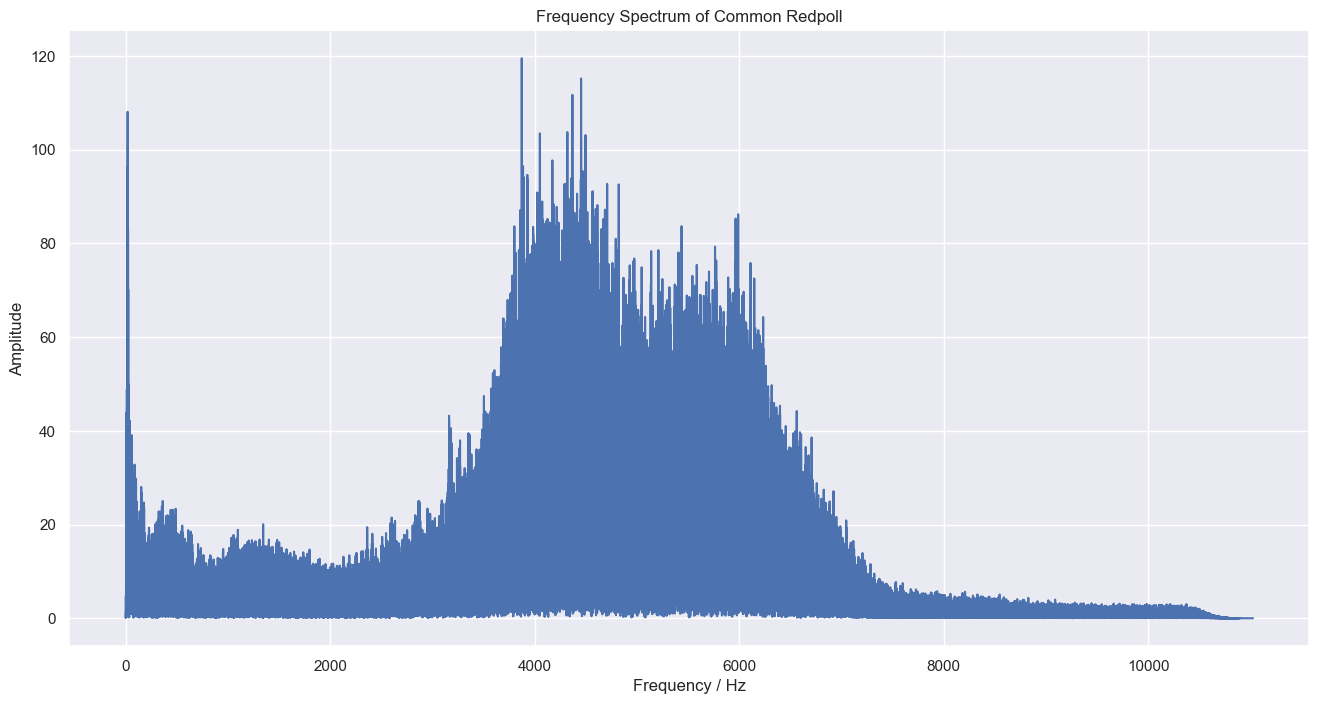

In [22]:
plot_frequency_spectrum("./bird/songs/songs/xc132608.flac", "Common Redpoll")

We see that There is a spike at frequency 0, this is likely due to **noise**.

## Marsh Warbler

The following is the frequency spectrum for **Marsh Warbler**

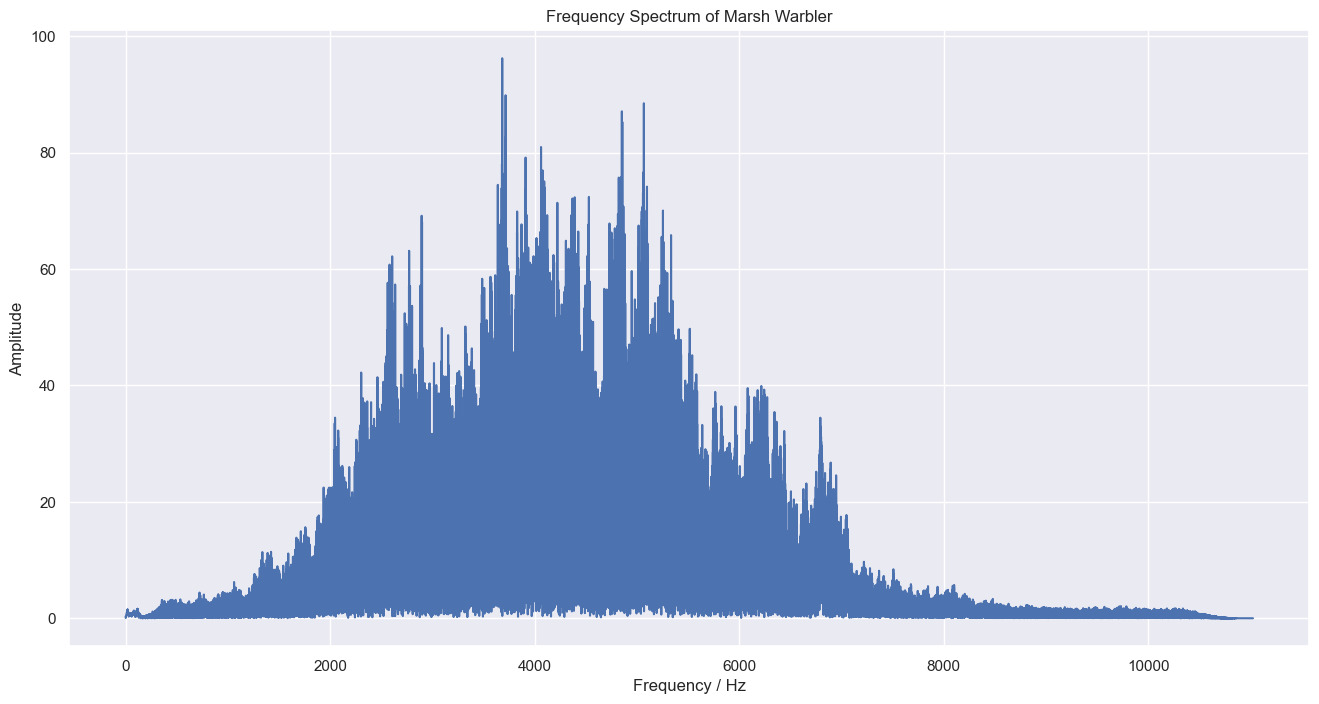

In [23]:
plot_frequency_spectrum("./bird/songs/songs/xc82715.flac", "Marsh Warbler")

## Comparison of Frequency Spectrum

To better visualise their differences, we plot them on the same graph. Note that we again truncate the recording duration to the shorter one. For the frequency analysis, we are more interested in the **distrbution** of the freuqency bands, so even if we did not truncate the durations, the amplitude may differ but the distribution will still be roughly the same.

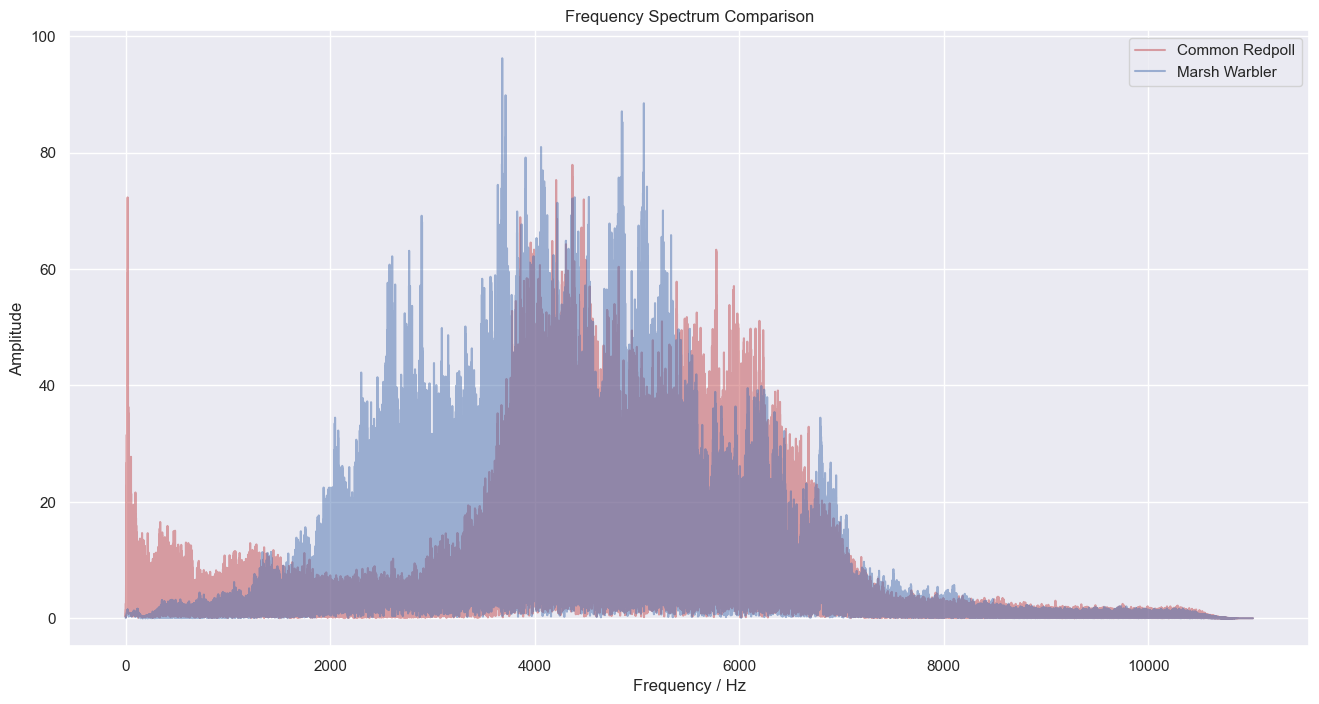

In [24]:
compare_frequency_spectrum("./bird/songs/songs/xc132608.flac", "./bird/songs/songs/xc82715.flac", "Common Redpoll", "Marsh Warbler")

We see that for the **Common Redpoll**, its frequency range is distributed between **3800Hz to 7000Hz**, while that of the **Marsh Warbler** is distributed between **2000Hz to 7000Hz**. This is not surpsing as the vocal range of song birds lie between **1000Hz to 8000Hz**. Note that the shapes of the graph imply that there is likely a presence of **noise** and we will attempt to *clean* this noise in the following sections

We see that the **Marsh Warbler** has clearly a more lower bound of vocal range than **Common Redpoll**. This suggsests that the frequency-domain can be an important feature.

## Spectral Centroid Analysis

### Common Redpoll

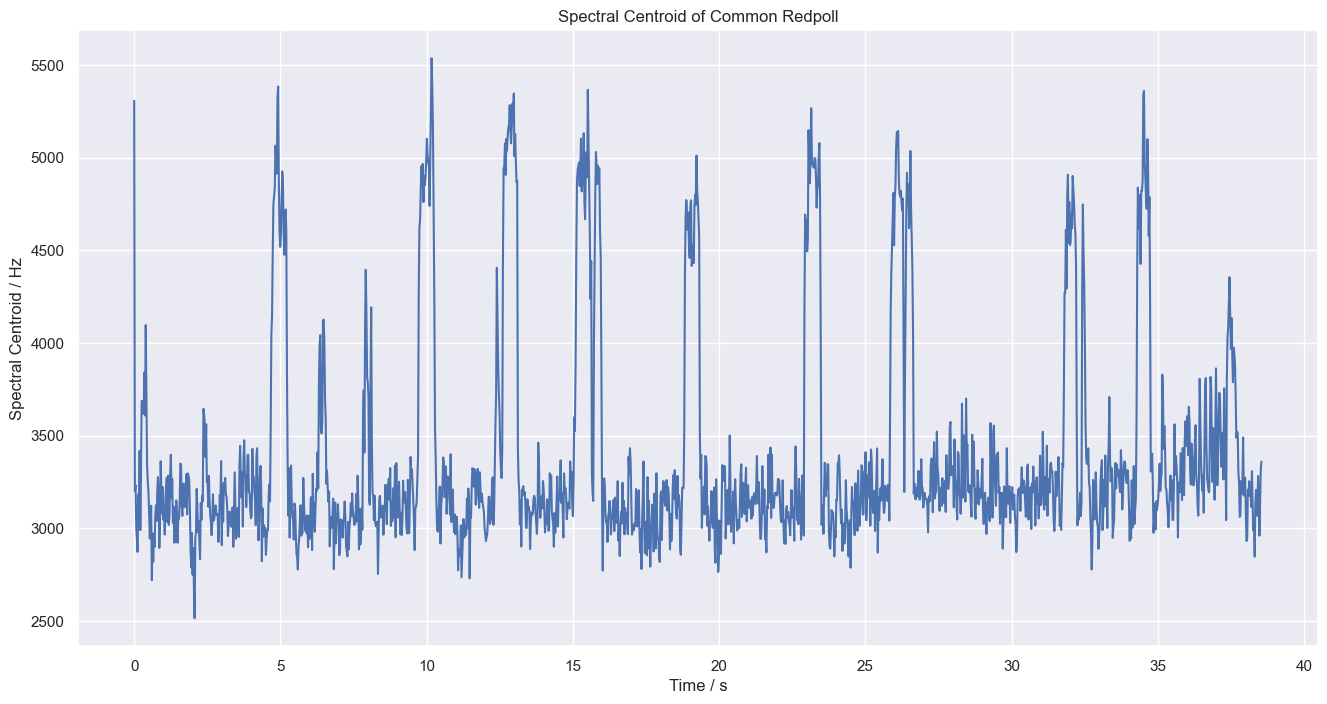

In [25]:
plot_spectral_centroid("./bird/songs/songs/xc132608.flac", "Common Redpoll")

We see that the frequency of **Common Redpoll** is concentrated at around **5250 Hz** 

### Marsh Warbler

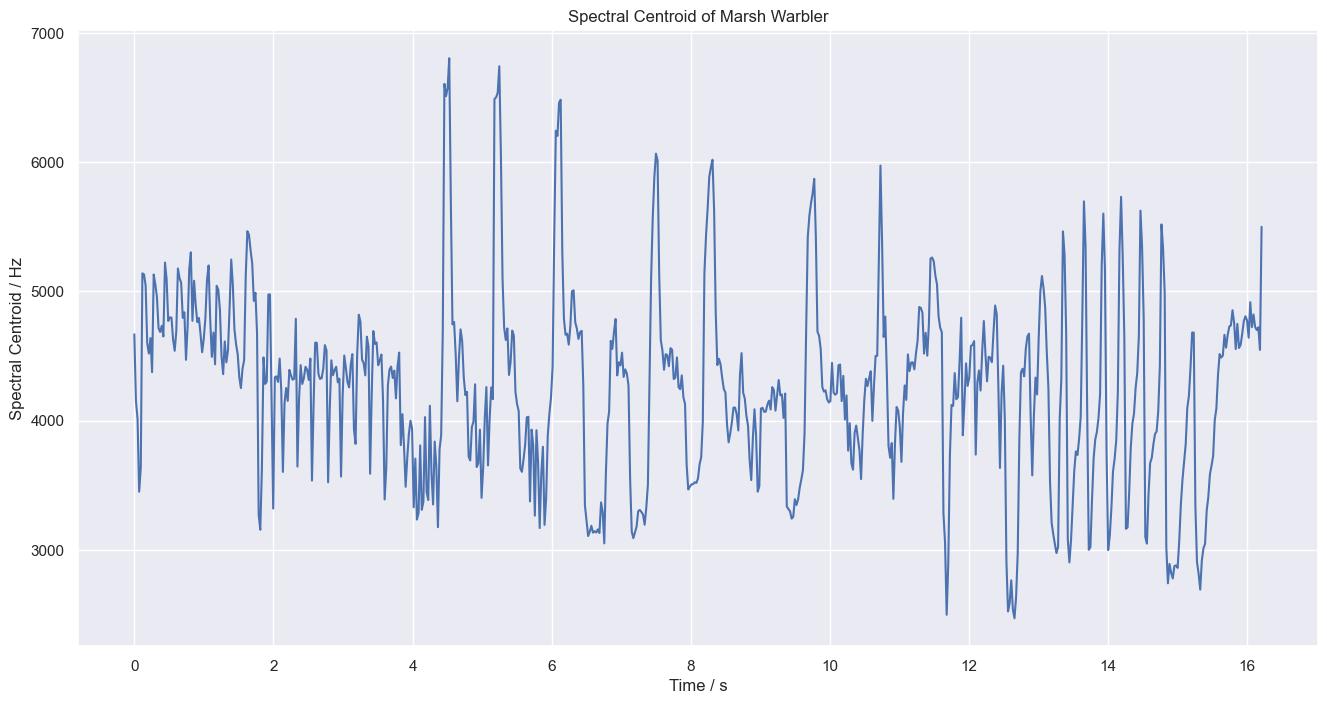

In [26]:
plot_spectral_centroid("./bird/songs/songs/xc82715.flac", "Marsh Warbler")

We see that the **Marsh Warbler** does not seem to have a uniform concentration, it centers around **6000 Hz**

## Comparsion of the Spectral Centroids

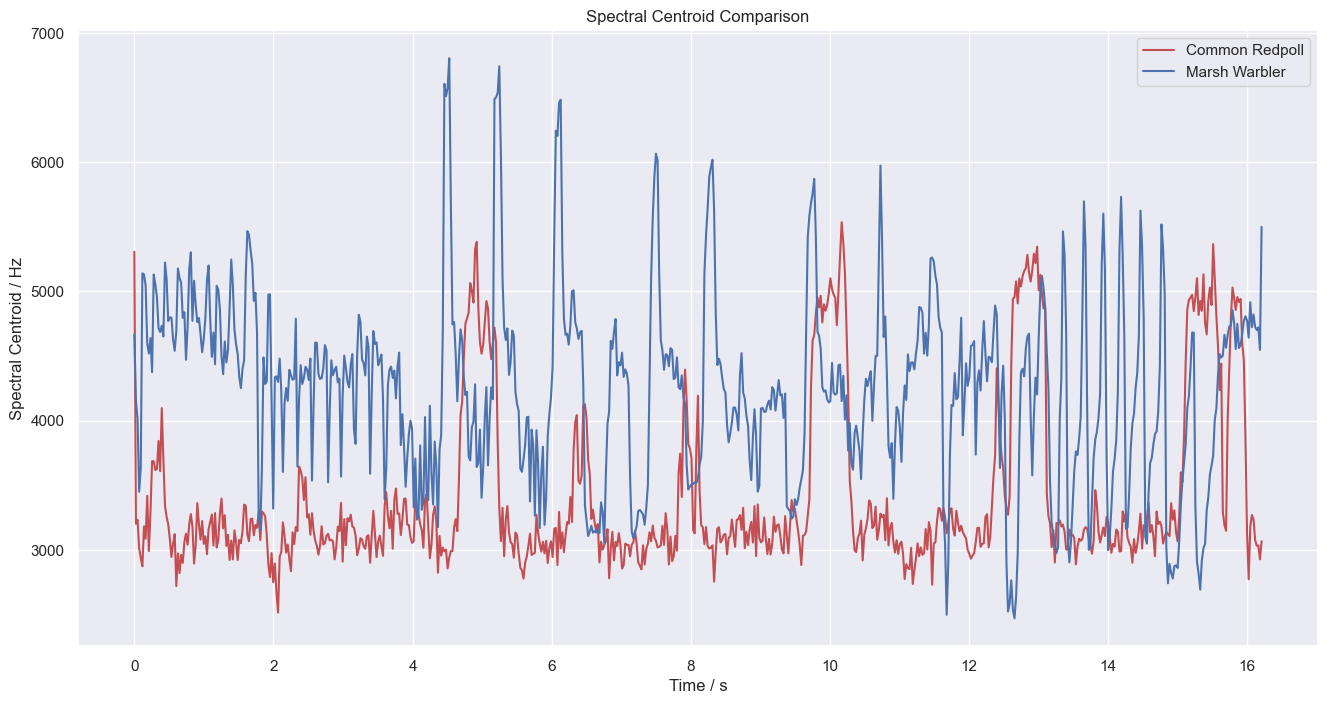

In [27]:
compare_spectral_centroid("./bird/songs/songs/xc132608.flac", "./bird/songs/songs/xc82715.flac", "Common Redpoll", "Marsh Warbler")

We see that the **Marsh Warbler** generally has a higher spectral centroid than the **Common Redpoll**. As such, spectral centroid can be an important feature in classifying the different species.

# **Time-Frequency Domain**

Often, we are interested in both the time domain and frequency domain. The time domain allows us to visualise how signals evolves over time, while frequency is an important characteristic of sound. Additionally, we would also want to visualise the amplitude of the signal since it is also an important feature. Time-frequency domain allows us to capture all these important information in a single graph

## **Spectrogram**

The y-axis represents the **frequency bins**, and the x-axis represents the **time**. The brigther the **colour**, the more the **energy** in that particular frequency bins (*hence more dominant*). We represent the axes in **logarithmic**, as it allows for better visualisation. This has to do with how we *perceive* **loudness** and **frequency**. As mentioned, this discussion is beyond the scope of the project. Most of the transformations have been abstracted by the libraries.

You can find find more information on how we perceive sound <a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5819010/">here</a>.


## **Mel Spectrogram**

A **Mel (as in melody) Scale** is a logarithmic scale that represnts the "perceived" pitch. Equal distances on the scale represent equal perceptual "distances". The Mel Spectrogram is essentially the "normal" spectrogram, but with its *frequencies* converted to **Mel scale**. This is done by applying a **Mel Filter**. How we interept the Mel Spectrogram is essentially the same, just that the frequency bins are now **perceptually relevant**. This is abstracted by the feature extractors in `librosa`.

<p style="text-align: center"><code>librosa.feature.melspectrogram(*, y=None, sr=22050, S=None, n_fft=2048, hop_length=512, win_length=None, window='hann', center=True, pad_mode='constant', power=2.0, **kwargs)</code></p>


## **Mel-Frequency Cepstral Coefficient (MFCC)**

The MFCC cepstrum takes multiple transformation of the signal wave. The mathematics involved in not within the scope of the project. The resultant is a graph of **cepstrum coefficient index** against **time**. The basic and superficial intuition is that during the final step, we applied the **inverse Fourier Transformation**, and hence its name. Its computations are abstracted by `librosa`. In this implementation, we take the **first 16** coefficients, as these keep most of the information

<p style="text-align: center"><code>librosa.feature.mfcc(*, y=None, sr=22050, S=None, n_mfcc=20, dct_type=2, norm='ortho', lifter=0, **kwargs)</code></p>

In [28]:

# Draw the spectrogram using Short-time-Fourier-Transformation
def plot_stft(path, title, is_signal=0, signal=None, sr=None):
    if is_signal==1:
        stft_spectrum_matrix = librosa.stft(signal, n_fft=FRAME_SIZE, hop_length=HOP_LEN)    
    else:
        waveform, sample_rate = librosa.load(path)
        stft_spectrum_matrix = librosa.stft(waveform, n_fft=FRAME_SIZE, hop_length=HOP_LEN)
    
    plt.figure(figsize=(16, 12))
    if is_signal==1:
        librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max), sr = sr, hop_length=HOP_LEN, y_axis='log', x_axis='time')
    else:
        librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max), sr = sample_rate, hop_length=HOP_LEN, y_axis='log', x_axis='time')
    plt.ylabel("Frequency / Hz")
    plt.xlabel("Time / s")
    plt.title(title)
    plt.colorbar(format='%+2.0f dB')
    plt.show()


# Draws the Mel Spectrogram, we pass signals and sample rate instead to account for reduced noise samples
def plot_mel_spectrogram(signal, sr, title):
    mel = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_LEN, n_mels=16)
    log_mel = librosa.power_to_db(mel)
    plt.figure(figsize=(16,12))
    librosa.display.specshow(log_mel, x_axis="time", y_axis="mel", sr=sr)
    plt.colorbar(format="%+2.f dB")
    plt.xlabel("Time / s")
    plt.ylabel("Mel Frequency / Hz")
    plt.title( "Mel Spectrogram of "+ title)


# Draws the MFCC cepstrum
def plot_mfcc(signal, sr, title):
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=32)
    plt.figure(figsize=(16,12))
    librosa.display.specshow(mfcc, x_axis="time", sr=sr)
    plt.colorbar(format="%+2.f")
    plt.ylabel("Index")
    plt.title( "MFCC spectrum of "+ title)

## Spectrogram Analysis

### **Spectrograms of Common Redpoll**

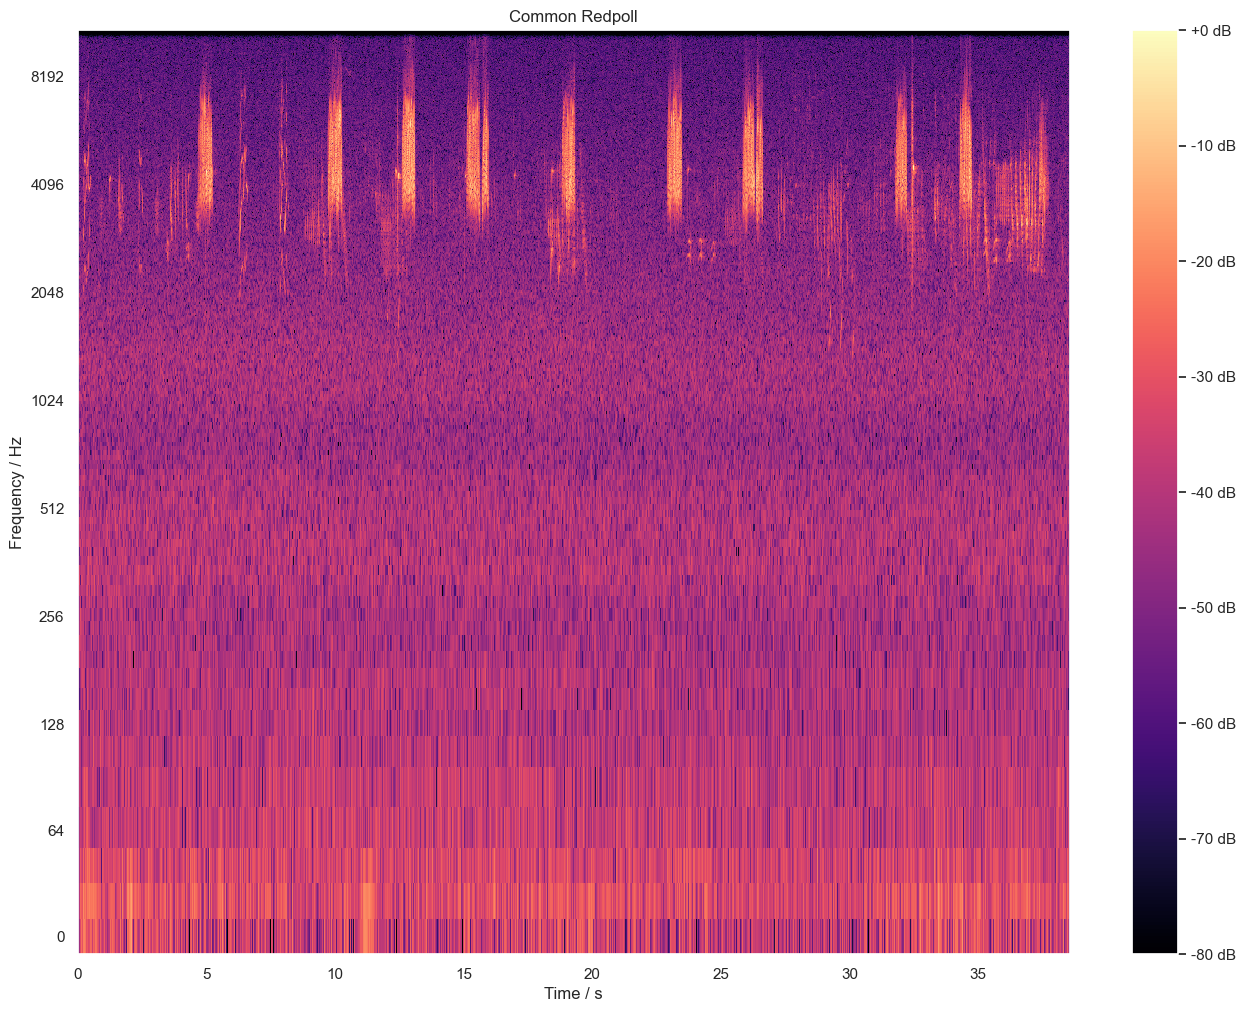

In [29]:
plot_stft("./bird/songs/songs/xc132608.flac", "Common Redpoll")

The fuzzy spectrogram again confirmed the presence of noise. We can see this from the fact that most of the graph is highlighted in orange, which means that all frequency intervals are strong in this sample, which does not make sense. We will attempt to see what the spectrogram looks like after cleaning this noise.

## **Noisereduce Library**

The `noisereduce` library abstracts the problem of cleaning the noise for us. The actual steps to clean noise involves actual mathematics which is beyond the scope of this project.

*"Noisereduce is a noise reduction algorithm in python that reduces noise in time-domain signals like speech, bioacoustics, and physiological signals. It relies on a method called "spectral gating" which is a form of Noise Gate. It works by computing a spectrogram of a signal (and optionally a noise signal) and estimating a noise threshold (or gate) for each frequency band of that signal/noise. That threshold is used to compute a mask, which gates noise below the frequency-varying threshold."*  

We will be using **Stationary Noise Reduction** in cleaning noises in our samples. According to the documentation, stationary noise reduction *keeps the estimated noise threshold at the same level across the whole signal*

Refer to the <a href="https://github.com/timsainb/noisereduce">documentation</a> for more details.

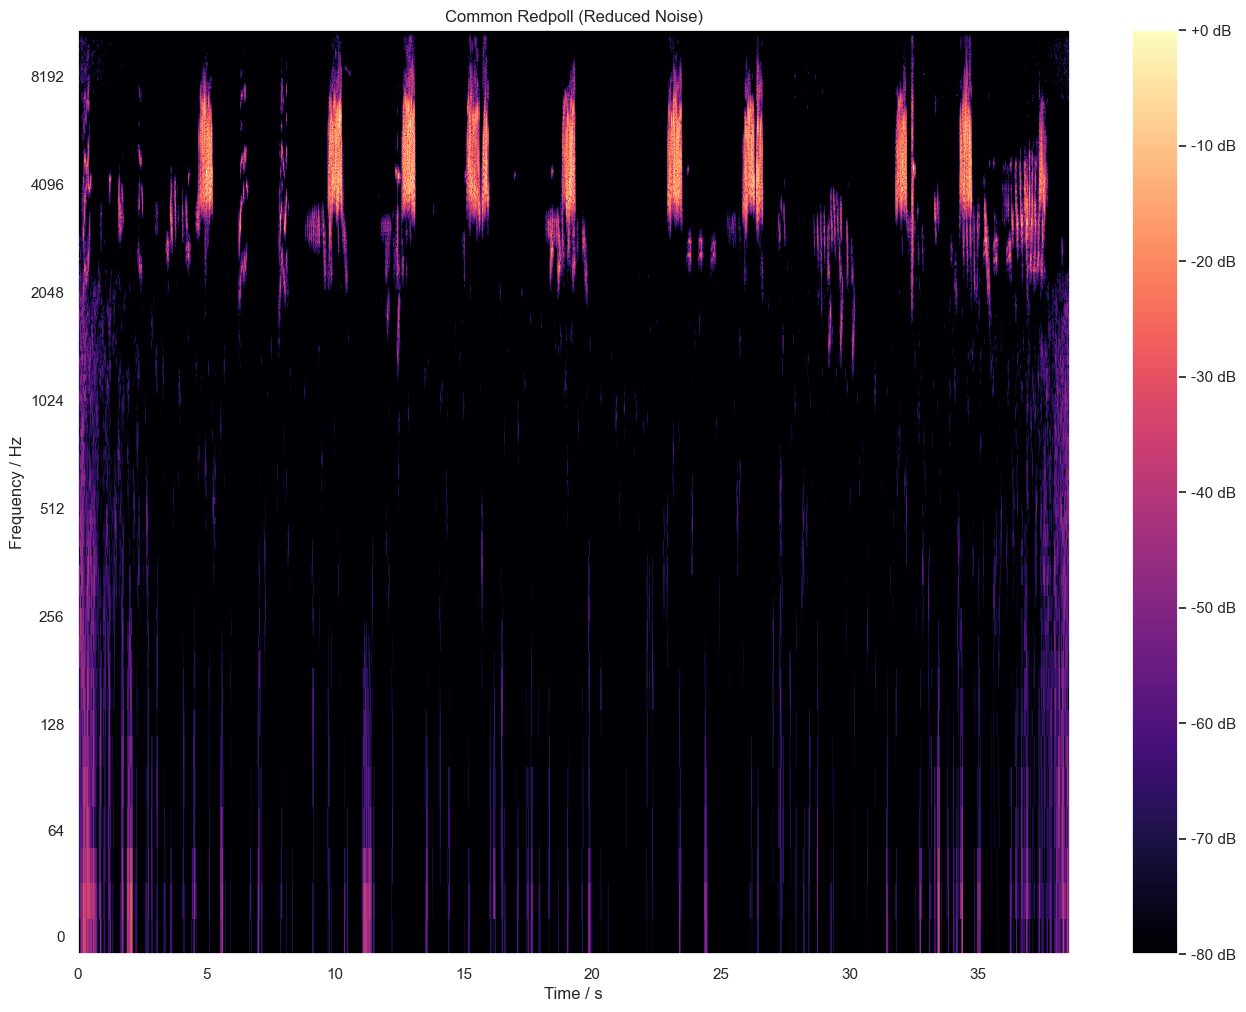

In [30]:
y, sr = librosa.load("./bird/songs/songs/xc132608.flac")
reduced_noise = nr.reduce_noise(y=y, sr=sr)
plot_stft(None, "Common Redpoll (Reduced Noise)", is_signal=1, signal=reduced_noise, sr=sr)

This version of the spectrogram allows **better visualisation**. We see that the highest **energy bands** are distributed between **frequency bins** of around **3000Hz to 8000Hz**

We next look at its **Mel Spectrogram**. The analysis is the same, but the it allows us to visualise the distributions better. The **mel bands** are set to 16.

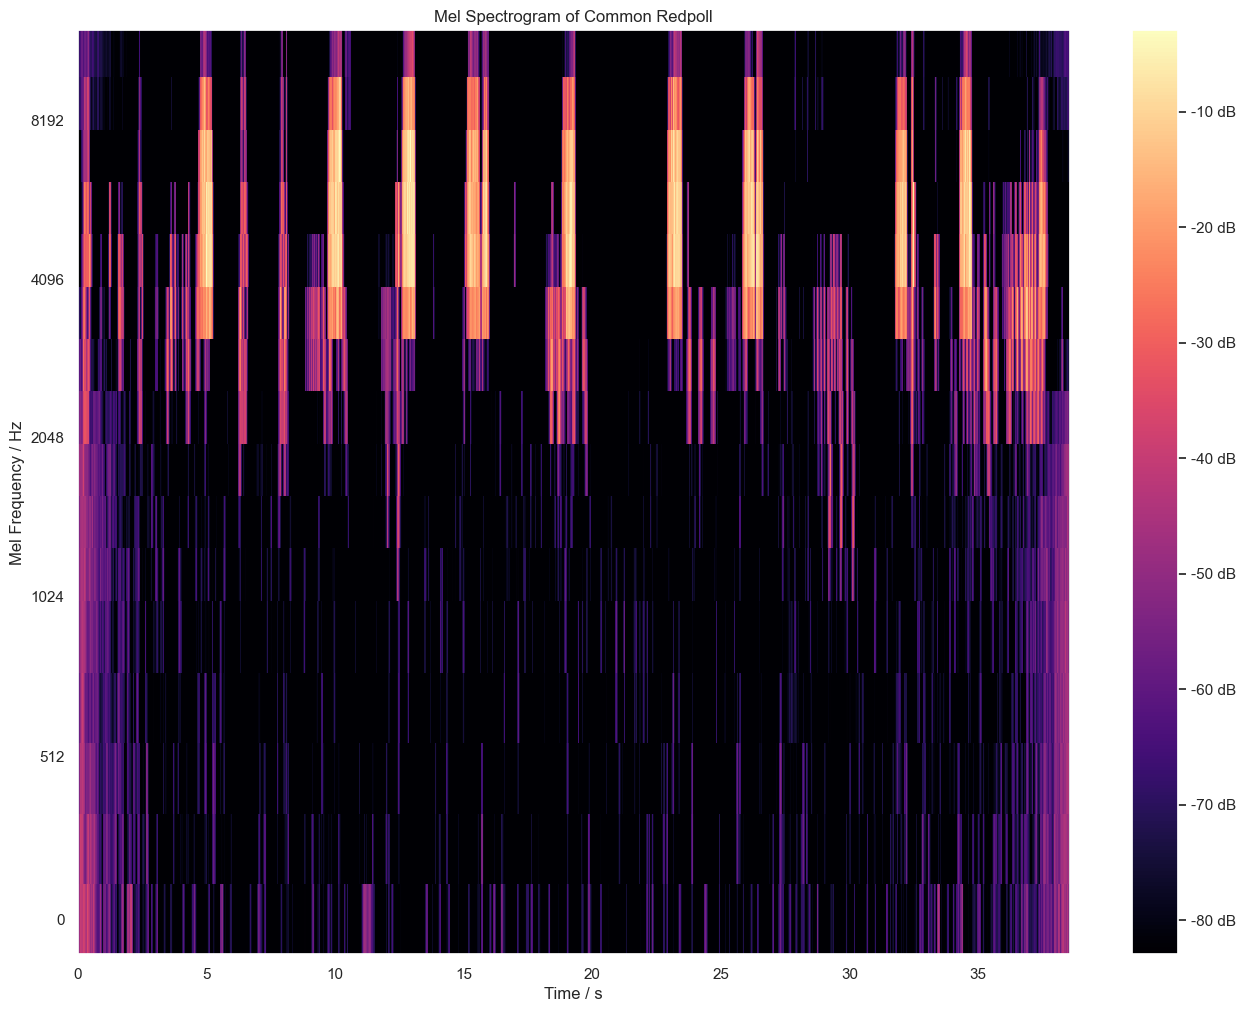

In [31]:
plot_mel_spectrogram(reduced_noise, sr, "Common Redpoll")

Next, we look at the MFCC spectrum.

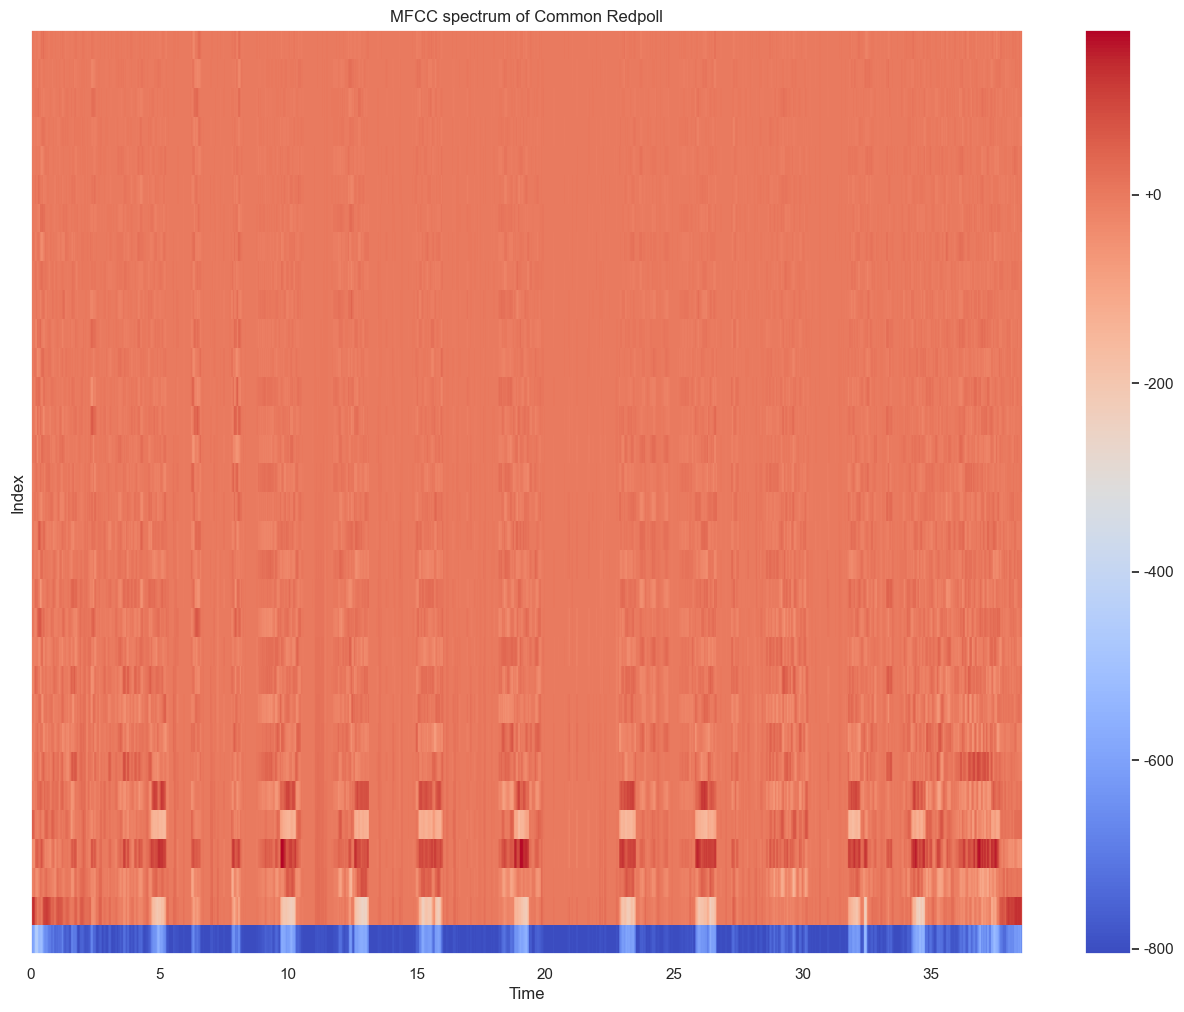

In [32]:
plot_mfcc(reduced_noise, sr, "Common Redpoll")

An interesting observation here is that, at each discrete time interval, we mainly see two distinct regions of index, which signify that the frequencies concentrate around those range

### **Spectrograms of Marsh Warbler**

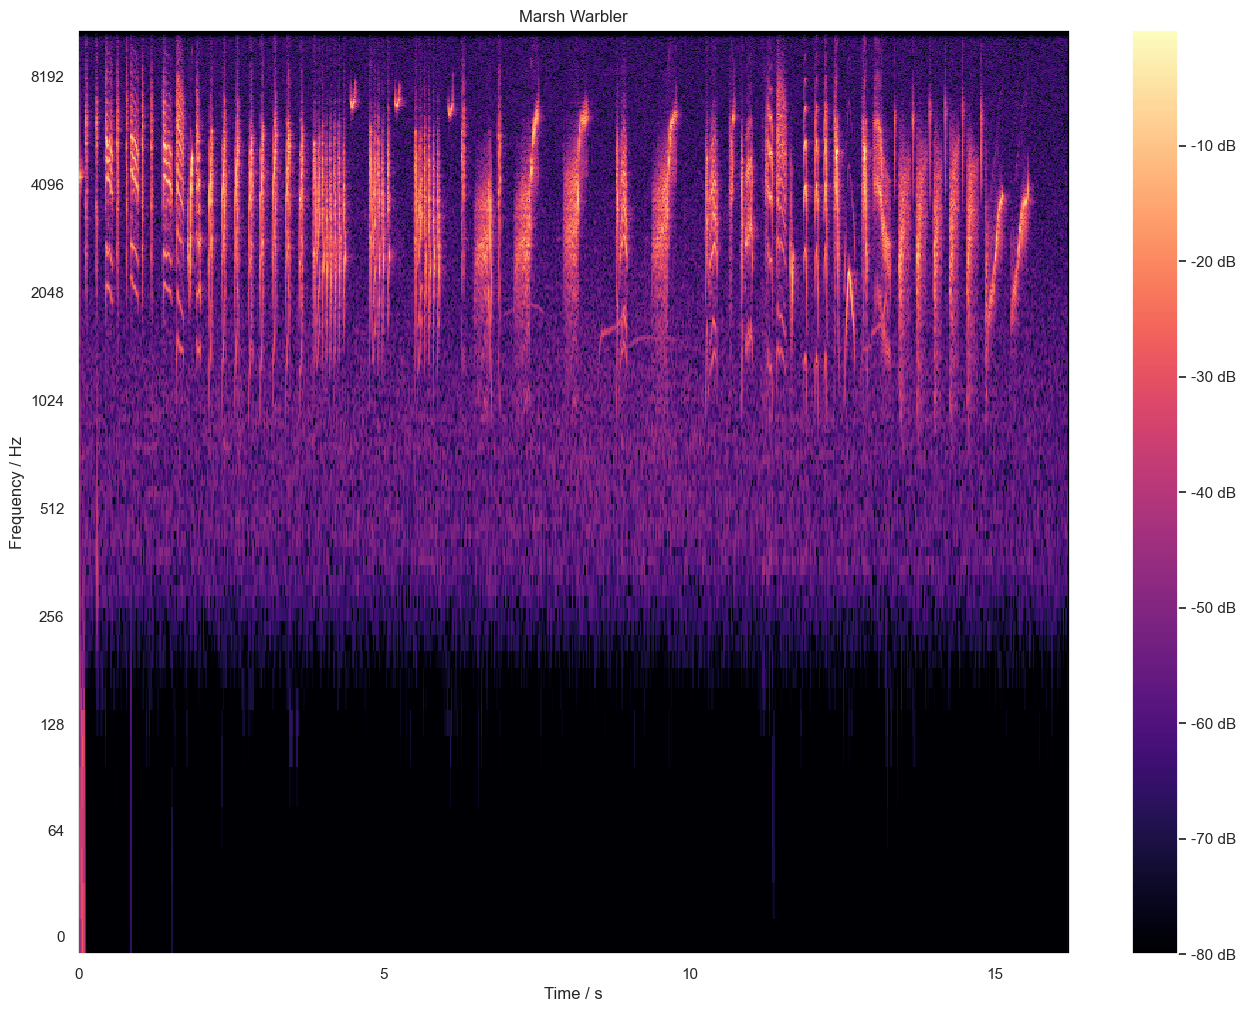

In [33]:
plot_stft("./bird/songs/songs/xc82715.flac", "Marsh Warbler")

While this spectrogram looked better than the uncleaned Common Redpoll, we clearly see fuzzy regions which is likely due to noise. We see if it can do better after reducing its noise.

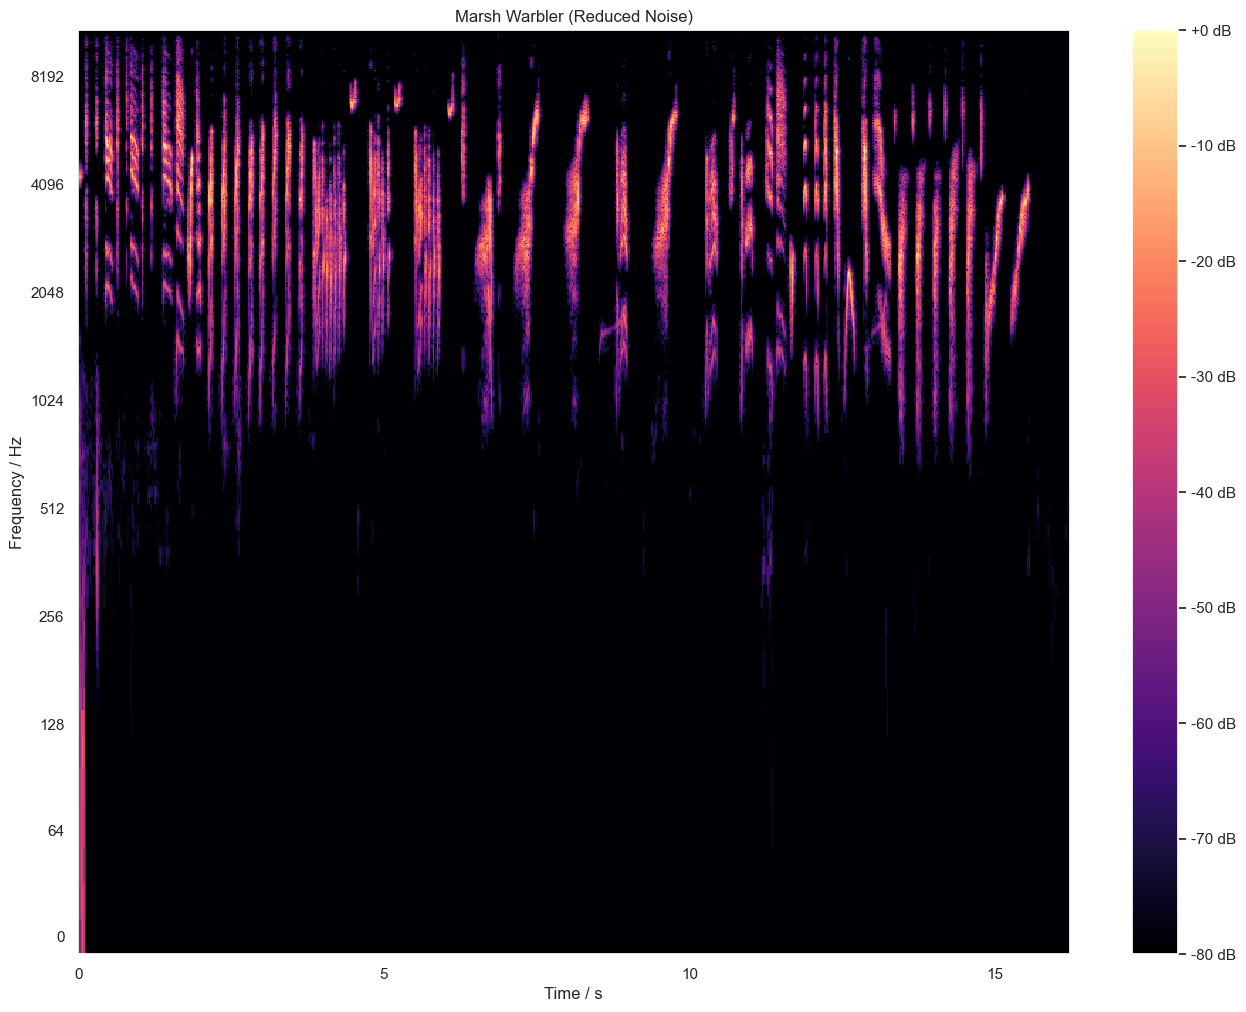

In [34]:
y, sr = librosa.load("./bird/songs/songs/xc82715.flac")
reduced_noise = nr.reduce_noise(y=y, sr=sr)
plot_stft(None, "Marsh Warbler (Reduced Noise)", is_signal=1, signal=reduced_noise, sr=sr)

We see that the highest **energy bands** are distributed between **frequency bins** of around **1000Hz to 8000Hz**. The **Marsh Warbler** seemed to have a higher vocal range than **Common Redpoll**. This is a similar obsevation to the **frequency spectrum** graphs that was explored in the earlier section. We see that spectrogram can be an **important feature** in classifying the bird species. 

We next look at its **Mel Spectrogram**. The analysis is the same, but the it allows us to visualise the distributions better. The **mel bands** are set to 16.

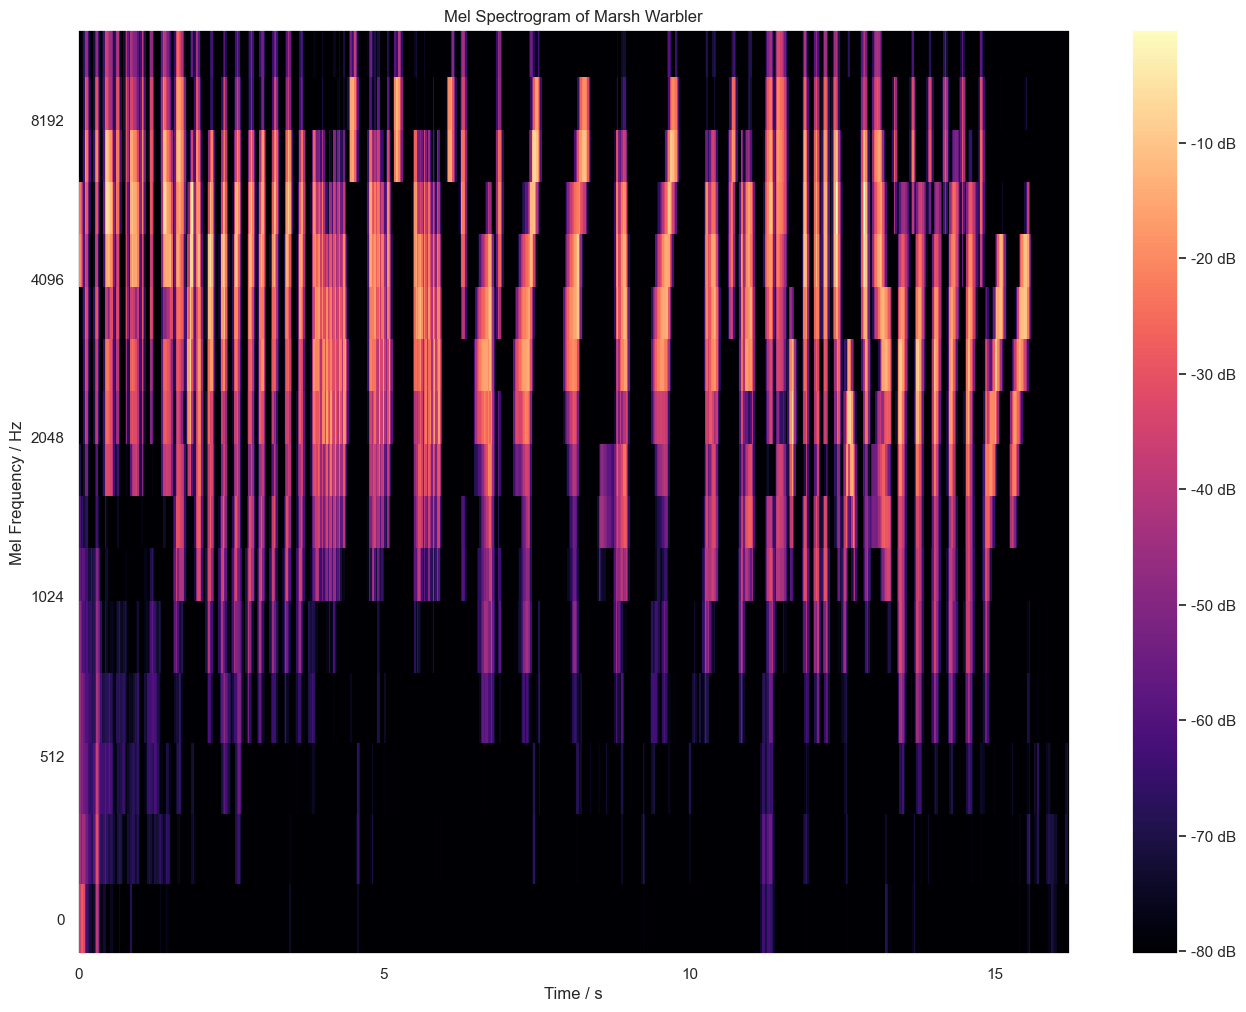

In [35]:
plot_mel_spectrogram(reduced_noise, sr, "Marsh Warbler")

Next, we look at its MFCC spectrum

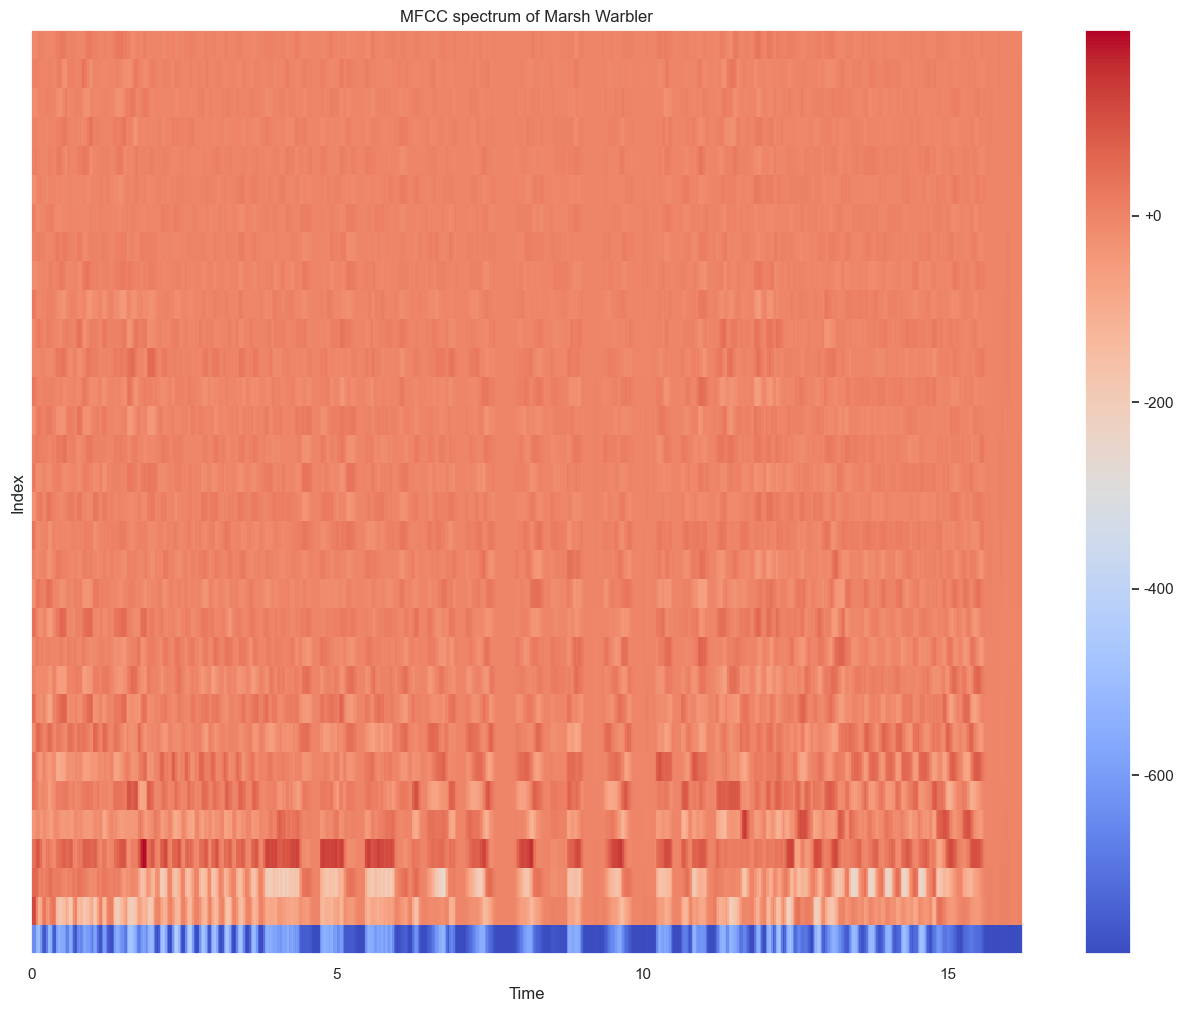

In [36]:
plot_mfcc(reduced_noise, sr, "Marsh Warbler")

An observation here is that unlike **Common Redpoll**, the indexes of **Marsh Warbler** at each time interval can be concentrated at many different regions, which means that the frequency range is wider.

## **Conclusion of Exploratory Data Analysis**

This concludes the exploratory data analysis. We gained some elementary insights on how we can train our models. In summary, we did the following:
- Gain an understanding of audio data
- Gain an understanding on how to extract measurable data from unstructured data (audio)
- Visualise the different audio features
- Visualise the difference between audio features using two different species
- Visualise the importance of the different audio features
- Gain an understanding how we can attempt to classify two birds based on their audio features

# **Data Cleaning and Preparation**

In the previous section, we have idenfitied some features that can be important in classifying the bird species. We now proceed to prepare our data for Machine Learning, which is perhaps the most crucial step that will affect the accuracy of the model

## **Removal of Environmental Noise**

We noted from the exploratory data analysis that the spectrograms look more distinct with the noise reduced. Hence, it is important that we remove these noise from our data, to prevent the models from unintentionally learning from these noise patterns

## **Standardising Shape of Data**

Many deep learning models including CNN requires that the shape of the training data to be the same. We clearly see from the exploratory data analysis that our data are of different shapes. We would want to specify a **fixed number of samples** for analysis. For audio data with duration **longer** than the fixed constant, we would want to **cut the waveform**. For audio data with duration **shorter** than the data, we would to **right pad it with silence**

## **Feature Scaling**

Feature scaling is important because different features have can take different ranges of values. For example, if we were to take the **amplitude envelope**, it ranges between **0.0 to 0.3**. Yet, if we look at the **spectrogram**, the frequency can range around **1000 to 8000**. This variation is due to the inherent characteristic of the features, which lead to a difference in **scale**. Features that have a **larger scale**, will introduce **bias** to models trained based on the computation of distance. (e.g. KNN) Therefore, we want to scale the data to the same scale.


## **Getting Started**

We have 88 classes split evenly with 3 samples each. According to https://arxiv.org/pdf/1706.07156.pdf, large number of classes and small samples sizes would require the use of Convoluted Neural Network (**CNN**) to yield improved results. In this paper, they standardised the sample duration by first clipping/padding them to the same duration. On the other hand, another common practice is to pad (with silence) all samples to the maximum duration. (check the sources to see if it is good)

We will reference these approaches to standardise the shape of input. We first find out the distribution of the duration of the samples.

In [37]:
directory = "./bird/songs/songs"

duration_array = []

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        t = librosa.get_duration(path=f)
        duration_array.append(t)

duration_df = pd.DataFrame(duration_array)
duration_df.describe()

0
count  264.000000
mean    67.107491
std     61.753228
min      3.265079
25%     26.714223
50%     46.667642
75%     80.267585
max    252.179751

Text(0.5, 1.0, 'Distribution of Data Shape')

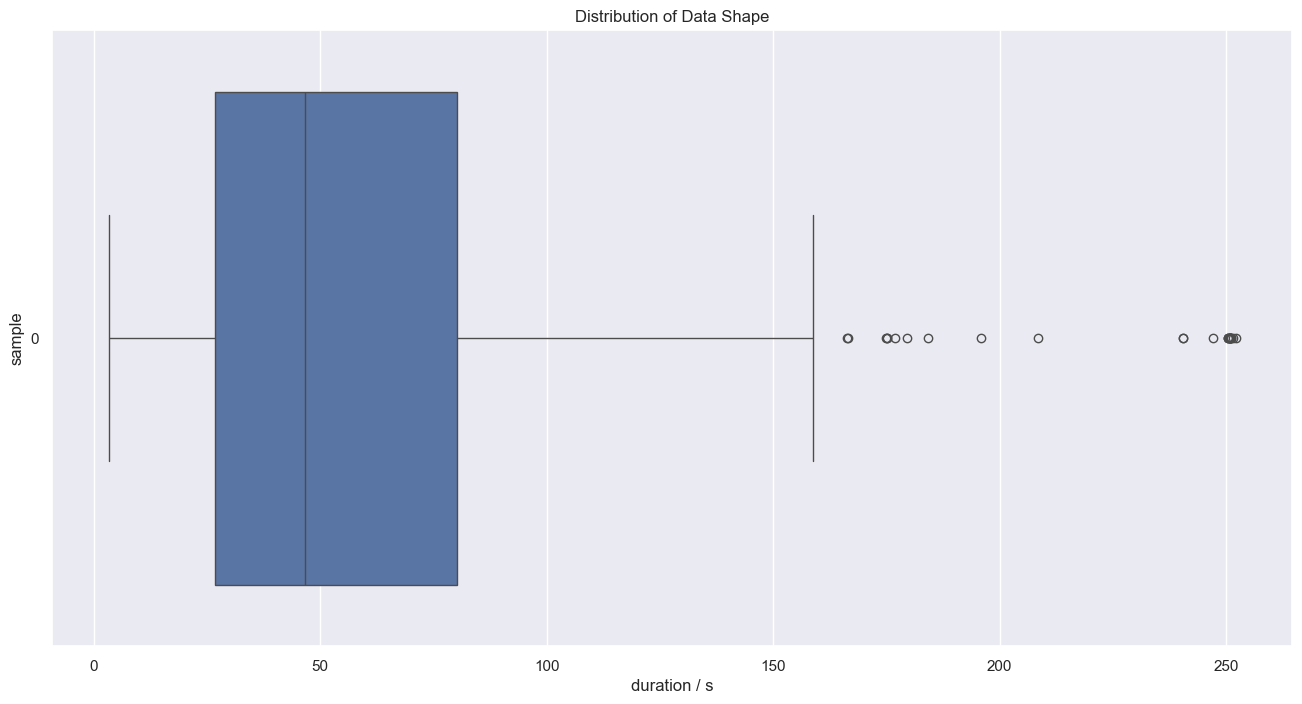

In [38]:
plt.figure(figsize=(16,8))
sns.boxplot(duration_df, orient="h")
plt.xlabel("duration / s")
plt.ylabel("sample")
plt.title("Distribution of Data Shape")

**Rationale for Pre-processing**

We see that there is a **huge standard deviation** and the extremes vary significantly between the range **3.26s to 252.18s** Truncating samples in this case to e.g. the mean, will result in a **loss of valuable data** that may be useful in the training of the model. However,  **padding silence to the longest duration** would mean that all 264 samples would be roughly **4 minute** long, which may lead to a greater time taken to train the models. This is because we see from the distribution that 250s is clearly a **outlier**. 

Given the above considerations, we decide to use the approach suggested by the (literature cited earlier), and to standardise them to a constant duration. To get a better estimate, we will first remove the outliers to see how the distribution would be like.

In [39]:
Q1 = duration_df.quantile(0.25)
Q3 = duration_df.quantile(0.75)
IQR = Q3 - Q1
index = ~((duration_df < (Q1 - 1.5 * IQR)) |(duration_df > (Q3 + 1.5 * IQR)))
cleaned_duration = duration_df[index]
cleaned_duration.describe()

0
count  238.000000
mean    50.097001
std     33.910518
min      3.265079
25%     24.678957
50%     42.174467
75%     69.655283
max    158.772018

We will standardise (pad/clip) the audio samples to **50s**. We will make use of the `audiomentations` libary's `AdjustDuration` API to adjust the samples. 

`AdjustDuration` : *Trim or pad the audio to the specified length/duration in samples or seconds. If the input sound is longer than the target duration, pick a random offset and crop the sound to the target duration. If the input sound is shorter than the target duration, pad the sound so the duration matches the target duration.*

Note that **50s**  using the sample rate **22050**, gives **1102500** in number of samples.

Based on the Exploratory Data Analysis, we know that features within the domain are closely related. Usually, **time-frequency domain** is used the most in training and **MFCC** is used. However, **MFCC** and **Mel Spectrogram** require us to specify the number of **Mel Bands** to use and is closely related to speech recognition and music genre classification. This is why the **Mel scales** were used so that we scale to our perceived range. However, for the purpose of **birdsong classification**, this advantage is not apparent. Additionally, the optimal number of bands to choose is not obvious. We would instead use the normal **spectrogram**. Additionally, we will also consider all domains: **time**, **frequency** and **time-frequency**. For other domains, the justifications are nothing more than the preliminary observations in the Exploratory Data Analysis. 

The following are the features that we will be considering. The default sample rate is set to **22050**, default channel set to **mono**:
- **Time Domain:** Zero Crossing Rate, Amplitude Envelope, 
- **Frequency Domain:** Spectral Centroid,
- **Time-Frequency Domain:** Spectrogram, Mel Spectrogram, MFCC

Before we get these features:
- Reduce the environmental noise
- Standardise shapes to 50s

## **Extracting Features from Audio Samples (time-frequency domain approach)**

Our first approach in training the models is to train them based on the **time-frequency domain**, which is a popular approach (https://calebrascon.info/AR/Topic4/addresources/features.pdf (refer to this paper)). We will extract all three features, namely **chromagram**, **mel spectrogram**, and **MFCC**, which is also a common practice. 


The code used for feature extraction for machine learning is based on the GitHub project by Zenkov[1]. 

- We used different values for the paremeters that better fit our model
- We did not specify a max frequency threshold as we are handling bird auido samples
- We followed Zenkov's approach and get the mean of each column of the resulting matrix of stft to create a feature array
- We also used his approach to apply `np.hstack` to stack the feature array horizontally to create a feature matrix
- We referenced his approach to return arrays of label and features
  
[1]: Zenkov, Ilia. (2020). sklearn-audio-classification. GitHub repository. Retrieved from https://github.com/IliaZenkov/sklearn-audio-classification


The following are the code snippets that made reference to the project:

In [230]:

def feature_chromagram(signal):
    stft_spectrogram=np.abs(librosa.stft(signal))
    chromagram=np.mean(librosa.feature.chroma_stft(S=stft_spectrogram, sr=SAMPLE_RATE).T,axis=0)
    return chromagram

def feature_melspectrogram(signal):
    melspectrogram=np.mean(librosa.feature.melspectrogram(y=signal, sr=SAMPLE_RATE, n_mels=32).T,axis=0)
    return melspectrogram

def feature_mfcc(signal):
    mfc_coefficients=np.mean(librosa.feature.mfcc(y=signal, sr=SAMPLE_RATE, n_mfcc=13).T, axis=0) 
    return mfc_coefficients


def get_features(signal):
        # chromagram = feature_chromagram(signal)
        melspectrogram = feature_melspectrogram(signal)
        # mfc_coefficients = feature_mfcc(signal)

        feature_matrix=np.array([])
        # feature_matrix = np.hstack(mfc_coefficients)
        feature_matrix = np.hstack(melspectrogram)
        # feature_matrix = np.hstack((melspectrogram, mfc_coefficients))
        # feature_matrix = np.hstack((chromagram, melspectrogram, mfc_coefficients))
        
        return feature_matrix

Unlike Zenkov's project, our audio samples' file ID does not have a class identifier tags. We defined our own functions with reference to his approach. 

We first proceed to create the class dictionary so that we get discrete integers that represents the bird species, instead of using character strings. Note that we used common English names instead of scientific names for the sake of simplicity, as it is not obvious to tell what kind of bird we are working on based on its scientific name. We also see that the file names of the audio samples does not have an obvious way for us to see its label.

In [67]:
key = [i for i in range(88)]
value = pd.unique(meta_data['english_cname'])

d = dict(zip(key,value))
bird_class = {v: k for k, v in d.items()}

print(bird_class)

{'Common Redpoll': 0, 'Marsh Warbler': 1, 'Sedge Warbler': 2, 'Eurasian Reed Warbler': 3, 'Long-tailed Tit': 4, 'Eurasian Skylark': 5, 'Meadow Pipit': 6, 'Tree Pipit': 7, 'Common Swift': 8, 'Canada Goose': 9, 'Dunlin': 10, 'European Nightjar': 11, 'European Goldfinch': 12, 'Eurasian Treecreeper': 13, 'European Greenfinch': 14, 'Black-headed Gull': 15, 'Western Jackdaw': 16, 'Rock Dove': 17, 'Stock Dove': 18, 'Common Wood Pigeon': 19, 'Northern Raven': 20, 'Carrion Crow': 21, 'Rook': 22, 'Common Cuckoo': 23, 'Eurasian Blue Tit': 24, 'Common House Martin': 25, 'Great Spotted Woodpecker': 26, 'Black Woodpecker': 27, 'Corn Bunting': 28, 'Yellowhammer': 29, 'Common Reed Bunting': 30, 'European Robin': 31, 'Common Chaffinch': 32, 'Eurasian Coot': 33, 'Common Snipe': 34, 'Common Moorhen': 35, 'Eurasian Jay': 36, 'Red-throated Loon': 37, 'Eurasian Oystercatcher': 38, 'Barn Swallow': 39, 'Eurasian Wryneck': 40, 'Willow Ptarmigan': 41, 'European Herring Gull': 42, 'Common Linnet': 43, 'River War

The `load_data()` function loads all the audio samples and returns array of labels as well as the array of features specified above. Note that the ordering of both the label and the feature dataframes **follow their ordering in the local directory, not the meta data `.csv` set**. 

Steps involved:
- load sample using `librosa`
- clean the audio sample to **reduced noise (`noisereduce`)** and **clip/pad to 50s (`audiomentations`)**
- get features from the cleaned signal using `librosa`
- append the features to feature array
- strip file names such that it matches the `filed_id` in `birdsong_metadata.csv`
- use `pandas` to search the corresponding name given by `english_cname` in the same row
- use `bird_class` dictionary to get the label
- append the label array

In [231]:
# we have already extracted the features and saved the array into a .txt
# commented out the code to prevent re-running


def clean_audio(signal):
    y1 = nr.reduce_noise(y=signal, sr=SAMPLE_RATE)
    transform = AdjustDuration(duration_seconds=50, p=1.0)
    y2 = transform(y1, sample_rate=SAMPLE_RATE)
    return y2


def load_data():
    directory = "./bird/songs/songs"
    label, feature = [], []
    print("Work In progress...")
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        if os.path.isfile(f):
            y, sr = librosa.load(f)
            # stripped_name = int(os.path.splitext(f)[0].split("xc", 1)[1].strip())
            # bird_name = meta_data[meta_data["file_id"]==stripped_name]["english_cname"].iloc[0]
            # class_number = int(bird_class[bird_name])
            sound_features = get_features(clean_audio(y))
            # label.append(class_number)
            feature.append(sound_features)
            

    print("Done")
    # return np.array(label), np.array(feature)   The label array has already been  extracted
    return np.array(feature)


In [232]:
# label_array, feature_array = load_data() the label array has already been extracted
feature_array = load_data()

Work In progress...
Done


We are going **to save the feature array** into a text file so that we **don't have to rerun the program every time**.

In [240]:
np.savetxt("feature_0_32_0", feature_array)

In [222]:
# comment out np.savetxt to prevent re-running

# np.savetxt("label_array", label_array)
# np.savetxt("feature_32_13", feature_array)

feature_df = pd.DataFrame(np.loadtxt("feature_12_12_12"))
label_df = pd.DataFrame(np.loadtxt("label_array", dtype="int"))

In [238]:
label_df = pd.DataFrame(np.loadtxt("label_array", dtype="int"))
feature_df = pd.DataFrame(feature_array)

We verify the the features that we get are correct. We should have **264 samples (rows)** and **180 features (columns)**.

The following are the feature break downs:
- Chromagram: **12 pitch classess**
- Mel Spectrogram: **128 Mel Frequency Bands**
- MFCC Cepstrum: **40 MFCC**

In [241]:
feature_df.head()

0             1             2             3             4   \
0  5.681109e-09  6.010492e-09  5.975971e-09  6.653387e-09  6.285227e-09   
1  5.632547e-12  3.426048e-11  4.075864e-11  2.746310e-11  7.330647e-11   
2  4.791985e-12  9.657211e-12  1.710164e-11  1.955792e-11  2.009658e-11   
3  9.029515e-10  6.705521e-10  1.550647e-09  1.615538e-09  7.510779e-10   
4  3.793722e-10  1.278026e-10  2.828939e-10  2.883685e-10  1.249237e-10   

             5             6             7             8             9   ...  \
0  6.459153e-09  7.776197e-09  8.695659e-09  7.052804e-09  7.821462e-09  ...   
1  2.565227e-10  1.207369e-10  5.851636e-09  2.670830e-06  1.583552e-04  ...   
2  1.698530e-11  1.554907e-11  1.365713e-11  1.265794e-11  1.100086e-11  ...   
3  1.698553e-10  3.341935e-11  1.040994e-10  1.614789e-10  4.692483e-10  ...   
4  3.370450e-11  2.407430e-10  4.085976e-10  3.995459e-10  2.204542e-10  ...   

         22        23            24        25        26            27  \
0  0.000033  0.000022  1.838105e-07  0.000002  0.000409  5.939084e-02   
1  0.000862  0.000644  1.732992e-04  0.000291  0.000838  2.406310e-04   
2  0.000012  0.000272  1.065933e-03  0.002175  0.003256  3.309516e-03   
3  0.002342  0.003150  5.996265e-04  0.000040  0.000004  2.681094e-07   
4  0.000638  0.000927  1.459621e-04  0.000010  0.000003  3.217890e-07   

             28            29            30            31  
0  1.902236e-01  1.538372e-02  1.172608e-04  6.475754e-06  
1  4.300646e-04  6.835607e-04  5.664312e-04  2.060467e-04  
2  1.647069e-03  4.039426e-04  5.838257e-05  2.440222e-06  
3  2.448203e-08  3.775388e-08  1.684664e-08  1.029000e-09  
4  4.252150e-08  4.437901e-09  1.059483e-09  7.053166e-10  

[5 rows x 32 columns]

We verify that the labels that we get are correct. We should have **264 labels (rows)** and **1 column only**.  We should have all **88 classess**, ranging from **0 to 87**. Each of the number of the class is uniquely map to a bird species via the `bird_class` dictionary. It is easy to tell which columns belong to which features through indexing, as in Zenkov's function definition, he concatenated them sequentially.

In [214]:
print(label_df.shape)
print(sorted(label_df[0].unique()))

(264, 1)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]


## **Feature Scaling: Standardisation**

Zenkov also mentioned the importance of feature scaling, which is a common practice in ensuring accuracy of distance-based models. We will use the `sklearn` library to abstrac the task for us. We have mentioned the need for scaling features in the previous section. For our project, we will be using **standardisation**, one of the feature scaling method.

### **The Concept of Standardisation**

reference(https://towardsdatascience.com/normalization-vs-standardization-cb8fe15082eb)

We want to scale the features such that their **mean is close to 0** and **standard deviation is close to 1**

We first examine basic information of our features. 
- **Chromgagram:** 12 features, indexed from [:, :11]
- **Mel Spectrogram:** 128 features, indexed from [:12, :139]
- **MFCC**: 40 features, indexed from [:140, :179]

chroma_feature = feature_df.loc[:, :11]
mel_feature = feature_df.loc[:12, :23]
mfcc_feature = feature_df.loc[:24, :35]

print("Chromagram Features:")
print()
print(chroma_feature.describe())
print()

print("Mel Spectrogram Features:")
print()
print(mel_feature.describe())
print()

print("MFCC Features:")
print()
print(mfcc_feature.describe())

We verify that there should a total of **180 columns**, which is the sum of all numbers of features.

We see that for each of group of the features, `pandas` actually `describe()` each individual column of the group. Instead, we would want to `describe()` the group as a whole. We can learn from Zenkov's implementations in navigating this problem.

Zenkov's implementations uses the following concept:
- `min = df.min().min()`
- `max = df.max().max()`
- `mean = df.stack().mean()`
- `std = df.stack().std()`

Although not directly explained, we can see the reasons behind the chaining in the methods. When we call the first method, we are actually operating **on each column of the dataframe**, which will give an **array**. The second time we use the method, we will be operating on the **resultant array**.

To verify our reasoning, we do a simple test. By calling the first `.min()`, we return **an array of minimum values**, which **corresponds to the minimum of each columns**, and hence we see that there are **12** of them, corresponding to the 12 pitch classes.

chroma_feature.min()

Hence, by chaining `.min()` again, we will return **a single integer, that is the minimum of the array**. This integer, **is also the minimum of the entire values in that group of feature**.

chroma_feature.min().min()

As such, the reason of using `df.stack().mean()` is clear as well, since calling `df.mean().mean()` will result in finding the mean of the resultant array, which is an array of mean of each of the columns. **We do not want to find the mean of the mean**.

Hence, we shall reference his implementation and define a function to print out the basic information of the features, namely its **max, min, mean and standard deviation**

In [224]:
def get_max(df):
    return df.max().max()


def get_min(df):
    return df.min().min()


def get_std(df):
    return df.stack().std()


def get_mean(df):
    return df.stack().mean()


def print_feature(df):
    print(f'min = {get_min(df):.2f}, \
            max = {get_max(df):.2f}, \
            mean = {get_mean(df):.2f}, \
            deviation = {get_std(df):.2f}') 


def describe_feature_df(df):
    chroma_feature = df.loc[:, :11]
    mel_feature = df.loc[:12, :23]
    mfcc_feature = df.loc[:24, :35]


    # note to change to df
    
    names = ["Chromagram Features", "Mel Spectrogram Features", "MFCC Features"]

    d = {
        "Chromagram Features": chroma_feature,
        "Mel Spectrogram Features": mel_feature,
        "MFCC Features": mfcc_feature,
    }

    for name in names:
        print(name)
        print_feature(d[name])
        print()


In [212]:
def get_max(df):
    return df.max().max()


def get_min(df):
    return df.min().min()


def get_std(df):
    return df.stack().std()


def get_mean(df):
    return df.stack().mean()


def print_feature(df):
    print(f'min = {get_min(df):.2f}, \
            max = {get_max(df):.2f}, \
            mean = {get_mean(df):.2f}, \
            deviation = {get_std(df):.2f}') 


def describe_feature_df(df):
    mel_feature = df.loc[:, :15]
    mfcc_feature = df.loc[:16, :28]


    # note to change to df
    
    names = ["Mel Spectrogram Features", "MFCC Features"]

    d = {
        "Mel Spectrogram Features": mel_feature,
        "MFCC Features": mfcc_feature,
    }

    for name in names:
        print(name)
        print_feature(d[name])
        print()


In [225]:
describe_feature_df(feature_df)

Chromagram Features
min = 0.02,             max = 0.64,             mean = 0.27,             deviation = 0.12

Mel Spectrogram Features
min = 0.00,             max = 0.46,             mean = 0.11,             deviation = 0.12

MFCC Features
min = -1010.62,             max = 50.00,             mean = -22.21,             deviation = 132.17



We shall apply standardisation transformation using `sklean`'s `StandardScaler`.

<p style="text-align: center"><code>`class sklearn.preprocessing.StandardScaler(*, copy=True, with_mean=True, with_std=True)</code></p>

*"Standardize features by removing the mean and scaling to unit variance."*

We verify the result after scaling, which is close to what we want. Note that because **number of mel bands**, **number of MFCC** are parameters to be tuned, we will have to test and try the best combination.

In [226]:
from sklearn.preprocessing import StandardScaler

unscaled_feature_df = feature_df

scaler = StandardScaler()
scaler.fit(unscaled_feature_df)
scaled_feature_df = pd.DataFrame(scaler.transform(unscaled_feature_df), index=unscaled_feature_df.index, columns=unscaled_feature_df.columns)

describe_feature_df(scaled_feature_df)

Chromagram Features
min = -2.11,             max = 3.05,             mean = -0.00,             deviation = 1.00

Mel Spectrogram Features
min = -1.68,             max = 1.52,             mean = -0.36,             deviation = 0.62

MFCC Features
min = -4.59,             max = 11.83,             mean = -0.14,             deviation = 0.95



Next, we will proceed to split our data set into **train, test**, in a ratio of **0.8 to 0.2**. We will be using `sklearn`'s `train_test_split`.

In [227]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(scaled_feature_df, label_df, test_size=0.2, random_state=1015)

# x_train, x_val, y_train, y_val  = train_test_split(x_train, y_train, test_size=0.25, random_state=123)

# **Model Training (Time-Frequency Domain)**

With that done, we will proceed to train our datasets using off-the-shelf models from `sklearn`. We will testing two models, namely:
- K-Nearest-Neighbour (KNN) Model
- Random Forest Model

## **Hyperparameter Tuning**

When we just pass the train data sets to the models, we are **actually using the default parameters**. Improving accuracy in general require us to **trial-and-error**. We have already **fixed the number of features extracted** (after testing of our own), hence the parameters left to tune are the configurations of the models.  

This involves testing a range of **arbitrary** values and **compare the performance** at each of the modified parameter. This tedious process has been abstracted by `sklearn` library.

There are two methods in fine tuning our hyperparameters, namely:
- Exhuastive Grid Search
- Randomised Parapmeter Optimisation

### **GridSearchCV**

### **RandomizedSearchCV**

*"RandomizedSearchCV implements a randomized search over parameters, where each setting is sampled from a distribution over possible parameter values. This has two main benefits over an exhaustive search:"*

- *A budget can be chosen independent of the number of parameters and possible values.*
- *Adding parameters that do not influence the performance does not decrease efficiency.*

(brush up on the explanation) 


We will be using **Exhuastive Grid Search** to test for **ALL combinations**. This is because our **sample size is small**.

## **K-Nearest-Neighbour (KNN)**

We first try the K nearest neightbour. Usually, we take the **square root** of the number of samples. Hence,
<center>$k = \sqrt{88} = 9$</center>

However, after testing, we decided to use $k = 2$ after accounting **overfitting** and ensuring a **better fit** on train

In [243]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(x_train,y_train)
print(f"Default Model's performance on train is: {round(knn.score(x_train, y_train)*100, 2)}%")
print(f"Default Model's performance on test is: {round(knn.score(x_test, y_test)*100, 2)}%")

Default Model's performance on train is: 60.19%
Default Model's performance on test is: 16.98%


The probability of predicting the class correctly by guessing is

<center>$p(x) = \frac{1}{88}\times100 = 1.14\%$</center>

We see that while the model's accuracy is not that good, it is at minimum, doing better than guessing.



## **K-Fold Cross-Validation**


(include explanation)

In [218]:
print(f"Default Model's cross-validation score is: {round(cross_val_score(knn, scaled_feature_df, label_df, cv=3).mean()*100, 2)}%")

Default Model's cross-validation score is: 21.97%


**A note on the limitation of the data set**

Unfortunately, because **we only have 3 samples in each class**, and that **the number of splits cannot exceed 3**. This is a limitation of the data set. To improve results, we should get more samples for **each class**, such that the smallest number of members in each class increases. Due to time constraints, as well as increase in computational time, i.e., **to increase `n_split` by 1, we need to add **88** samples**. For a CV of **5 folds**, the total number of samples would increase to **440** .

## **Analysis of the KNN model**

Aagain, we see that the accuracy is bad, although it is better than guessing. There are only **3 members in each class**, yet we have **88 classes**. 


Because we have so many classes yet so few samples in each case, it is reasonable to see the KNN model is not going to be suitable for this analysis. We proceed to try different machine learning method.


## **Random Forest**

We will now use the random forest model, which is a decision tree model.

In [244]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=1015)
model.fit(x_train, y_train.values.ravel())
print(f'Default Random Forest Model accuracy on train:    {round(100*model.score(x_train, y_train), 2)}%')
print(f'Default Random Forest Model accuracy on test:    {round(100*model.score(x_test, y_test), 2)}%')
print(f"Default Random Forest Model cross-validation score:    {round(100*cross_val_score(model, scaled_feature_df, label_df, cv=3).mean(), 2)}%")

Default Random Forest Model accuracy on train:    100.0%
Default Random Forest Model accuracy on test:    15.09%
Default Random Forest Model cross-validation score:    26.52%


## **Examining Default Parameters (Random Forest)**

Let's Examine the **default parameters** for the `RandomForestClassifier` from the `sklearn` library. These parameters are taken from its documentations:

```
{
    n_estimators: int, default=100;
    criterion: {“gini”, “entropy”, “log_loss”}, default=”gini”;
    max_depth: int, default=None;
    min_samples_leaf: int or float, default=1;
    min_weight_fraction_leaf: float, default=0.0;
    max_features: {“sqrt”, “log2”, None}, int or float, default=”sqrt”;
    max_leaf_nodes: int, default=None;
    min_impurity_decrease: float, default=0.0;
    bootstrap: bool, default=True;
    oob_score: bool or callable, default=False;
    n_jobs: int, default=None;
    random_state: int, RandomState instance or None, default=None;
    verbose: int, default=0;
    warm_start: bool, default=False;
    class_weight: {“balanced”, “balanced_subsample”}, dict or list of dicts, default=None;
    ccp_alpha: non-negative float, default=0.0;
    max_samples: int or float, default=None;
    monotonic_cst: array-like of int of shape (n_features), default=None;
}
```

We see that there are many parameters that we can tune. Traditionally, we focus on some of them that are likely to be more impactful. We quote the documentation and explain what the features do:
- `n_estimators`: It specifies the **number of decision trees** in the model, and the default is set to **100**
-  `max_depth`: It specifies the maximum depth of each tree in the random forest model. This is a classic parameter - higher depth will improve train accuracy, but may lead to overfitting and lower test accuracy. An important thing to note is that, the **default is set to None**, which means the tree can expand **infinitely**, and we do not want that
-  `min_samples_split`: The minimum number of samples required to split an internal node. The default is set to 2
-  `min_samples_leaf`: The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches.  The default is set to 1
-  `criterion`: The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “log_loss” and “entropy” both for the Shannon information gain. The default used is `gini`
- `max_feature`: The number of features to consider when looking for the best split, the default is set to the **Square root of the total number of samples**



We now set the **hyperparameter space** that we want to test. Note that again, we can only have **3 folds**. Because `GridSearch` is an extension of the k-fold cross validation, we don't have to do the cross-validations again. We have tested the parameters a few times and zoomed in on the few paramters

In [84]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
    # "max_depth" : range(5, 20),
    # "min_samples_leaf": range(2, 10),
    # "n_estimators": [80, 100, 120],
    # "min_samples_split": range(2, 10),
# }

# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
# grid_search.fit(x_train, y_train.values.ravel())
# print("Best parameters found: ", grid_search.best_params_)
# print("Best score is ", grid_search.best_score_)


Best parameters found:


```
{
    'max_depth': 14,
    'min_samples_leaf': 2,
    'min_samples_split': 2,
    'n_estimators': 120
} 
```

Best score is  0.2511737089201878

To save the time from re-running the grid search, we used the `pickle` library to save the model.

In [85]:
filename = "random_forest_gridsearch.sav"
# pickle.dump(grid_search, open(filename, 'wb'))

In [86]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(x_test, y_test)
print(f"Mean cross-validated score of Optimised Model:    {round(loaded_model.best_score_*100, 2)}%")
print(f'Optimised Random Forest Model accuracy on train:    {round(100*loaded_model.score(x_train, y_train), 2)}%')
print(f'Optimised Random Forest Model accuracy on test:    {round(100*loaded_model.score(x_test, y_test), 2)}%\n')

ValueError: X has 36 features, but RandomForestClassifier is expecting 180 features as input.

## **Evaluation of Grid Search Optimisation**

Interestingly, after optimising the parameters, we see that the accuracy on test **decreased**, as well as **cross validation score**. There could be many reasons why this occurred:
- The default combinations were already the best / better by **chance**
- The optimised model may be **over-fitting**
- The best parameters **may not be found** in the given parameter grid defined by us
- Our data set is too small, with very low members per class (limitation of the data set)
- The chosen model may not be the best model to use


since the optimised model doesn't perform as expected, we will use the **default configuration**

## **Evaluation of Optimised Random Forest Classifier**

In [ ]:
print("The Actual classes present in test:\n")
print(np.array(y_test.iloc[:, 0]))
print()
y_pred_test = model.predict(x_test)

print("The classes that the model predicted in the test:\n")
print(y_pred_test)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


conf_matrix = confusion_matrix(y_test, y_pred_test, labels=[i for i in range(88)])

f = plt.figure(figsize=(16, 16))

sns.heatmap(conf_matrix, fmt='d')

To get clearer understanding of the performance of the model, we will look at different metric.

(include explanation)

This has been abstracted by `sklearn`'s `classification_report`

In [87]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.50      1.00      0.67         1
          16       0.00      0.00      0.00         1
          17       0.33      1.00      0.50         1
          18       0.00      0.00      0.00         2
          19       1.00      0.50      0.67         2
          20       0.00    

In our problem, if we want to check for the presence of an endangered bird species, then we are more concerned about **maximising recall**. We want to **minimise false negatives**, that is, we would rather identify falsely, that an endangered species is nearby if we are able to ensure the likelihood of actually finding one.

As such, in this case, we would want to increase the accuracy of **recall** in this model.

**Limitation of Data Set**  
Again, we note that a problem here is due to the **large number of classes** and **small number of members**, the **test set** was not able to capture all the possible classes, and instead, only accounts for **41 unique classess**. We also want to note that because the **member size is so small**, it limits the performance of the model, specifically, the mappings are limited.

In [ ]:
print(y_test.iloc[:, 0].nunique())

In [221]:
from sklearn.svm import SVC

svc_model = SVC()
svc_model.fit(x_train, y_train)
print(f'SVC Model\'s accuracy on training set is {round(100*svc_model.score(x_train, y_train),2)}%')
print(f'SVC Model\'s accuracy on test set is {round(100*svc_model.score(x_test, y_test),2)}%')
print(f"Default SVC cross-validation score:    {round(100*cross_val_score(svc_model, scaled_feature_df, label_df, cv=3).mean(), 2)}%")

SVC Model's accuracy on training set is 54.03%
SVC Model's accuracy on test set is 7.55%
Default SVC cross-validation score:    25.76%


# **Deep Learning Model**

We will be following the https://arxiv.org/pdf/2206.07511.pdf multi modulality approach. We will be making references to the source code of the paper on their GitHub page https://github.com/turab45/Investigating-Multi-Feature-Selection-and-Ensembling-for-Audio-Classification/blob/master/multi-dodality%20on%20gujrati%20digits.ipynb

In [ ]:

def feature_zcr(signal):
    feature = librosa.feature.zero_crossing_rate(y=signal, frame_length=FRAME_SIZE, hop_length=HOP_LEN)[0]
    return feature


def feature_centroid(signal):
    feature = librosa.feature.spectral_centroid(y=signal, sr=SAMPLE_RATE, hop_length=HOP_LEN, n_fft=FRAME_SIZE)[0]
    return feature


def feature_spectrogram(signal):
    y1 = np.abs(librosa.stft(signal))
    # get the mean of each column of the resulting matrix to create a feature array
    feature = np.mean(y1.T,axis=0)
    return feature

